# Practico 10: Feature Selection

🎯 Objetivos¶

Implementar PCA y analizar componentes principales

Aplicar Feature Selection con múltiples métodos

Comparar PCA vs Feature Selection

Evaluar trade-offs en contexto de negocio

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.impute import SimpleImputer
import warnings
warnings.filterwarnings('ignore')

# Configuración
np.random.seed(42)
plt.style.use('default')
sns.set_palette("husl")

print("=" * 80)
print("ASSIGNMENT UT3-10: PCA y Feature Selection - Ames Housing Dataset")
print("=" * 80)

# ========== FUNCIÓN DE CARGA Y PREPROCESAMIENTO RÁPIDO ==========
def quick_load_and_preprocess_ames(filepath='train.csv'):
    """
    Carga y preprocesa Ames Housing en un solo paso
    (Ya hiciste esto en tareas anteriores, aquí es versión simplificada)
    """
    print("\n🏠 CARGANDO Y PREPROCESANDO AMES HOUSING...")

    # Cargar dataset
    df = pd.read_csv(filepath)
    print(f"✅ Dataset cargado: {df.shape[0]:,} casas, {df.shape[1]} columnas")

    # Eliminar 'Id' (no predictivo)
    df = df.drop('Id', axis=1, errors='ignore')

    # Identificar tipos de variables
    numerical_cols = df.select_dtypes(include=['int64', 'float64']).columns.tolist()
    categorical_cols = df.select_dtypes(include=['object']).columns.tolist()

    # Remover target de features
    if 'SalePrice' in numerical_cols:
        numerical_cols.remove('SalePrice')

    print(f"✅ Features numéricas: {len(numerical_cols)}")
    print(f"✅ Features categóricas: {len(categorical_cols)}")

    # Imputar valores faltantes
    num_imputer = SimpleImputer(strategy='median')
    df[numerical_cols] = num_imputer.fit_transform(df[numerical_cols])

    cat_imputer = SimpleImputer(strategy='most_frequent')
    df[categorical_cols] = cat_imputer.fit_transform(df[categorical_cols])

    print(f"✅ Missing values imputados")

    # Label encoding para categóricas
    le = LabelEncoder()
    for col in categorical_cols:
        df[col] = le.fit_transform(df[col].astype(str))

    print(f"✅ Categóricas encoded")

    # Separar X y y
    X = df.drop('SalePrice', axis=1)
    y = df['SalePrice']

    print(f"\n✅ DATASET LISTO:")
    print(f"   X shape: {X.shape} ({X.shape[1]} features)")
    print(f"   y shape: {y.shape}")
    print(f"   Precio promedio: ${y.mean():,.0f}")
    print(f"   Precio mediana: ${y.median():,.0f}")

    return X, y, X.columns.tolist()

# ========== EJECUTAR CARGA RÁPIDA ==========
# TODO: Completa con el path correcto
# ========== EJECUTAR CARGA RÁPIDA ==========
X, y, feature_names = quick_load_and_preprocess_ames('train.csv')

print(f"\n📊 RESUMEN DEL DATASET:")
print(f"   Total features: {X.shape[1]}")
print(f"   Total casas: {X.shape[0]:,}")
print(f"   Ejemplos de features: {feature_names[:10]}")

ASSIGNMENT UT3-10: PCA y Feature Selection - Ames Housing Dataset

🏠 CARGANDO Y PREPROCESANDO AMES HOUSING...
✅ Dataset cargado: 1,460 casas, 81 columnas
✅ Features numéricas: 36
✅ Features categóricas: 43
✅ Missing values imputados
✅ Categóricas encoded

✅ DATASET LISTO:
   X shape: (1460, 79) (79 features)
   y shape: (1460,)
   Precio promedio: $180,921
   Precio mediana: $163,000

📊 RESUMEN DEL DATASET:
   Total features: 79
   Total casas: 1,460
   Ejemplos de features: ['MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig']


🤔 Pregunta Reflexiva 1:

¿Con 80+ features, esperarías que todas sean igualmente importantes para predecir precio?

No, no esperaría que las más de 80 features tengan la misma importancia al predecir el precio. Muchas variables pueden estar altamente correlacionadas o aportar poca información nueva. 

¿Qué problemas puede causar tener tantas features? (Piensa en: overfitting, velocidad, interpretabilidad)

Overfitting: el modelo puede aprender ruido y patrones específicos del conjunto de entrenamiento, perdiendo capacidad de generalización.

Velocidad: más variables implican mayor tiempo de cómputo y complejidad en la optimización.

Interpretabilidad: resulta difícil entender qué factores influyen realmente en el precio si hay demasiadas variables correlacionadas o irrelevantes.


¿Conoces la diferencia entre PCA (transformar features) y Feature Selection (seleccionar features)?

PCA (Principal Component Analysis) transforma las variables originales en nuevas combinaciones lineales (componentes principales) que explican la mayor varianza posible. Se pierden los nombres originales, pero se conserva la información.

Feature Selection selecciona un subconjunto de las variables originales más relevantes según algún criterio (estadístico, modelo, etc.). Mantiene las features originales, lo que facilita la interpretación.

## Parte 2: PCA - Análisis de Componentes Principales (35 min)¶
⏱️ Tiempo esperado: ~35 minutos (PCA con 80 features toma más tiempo)

💡 Contexto de Negocio: Con 80+ features, el modelo es complejo, lento de entrenar, y difícil de interpretar. PCA te permitirá reducir a 10-15 componentes mientras mantienes 80-90% de la información. Esto es crítico para: - ⚡ Velocidad: Modelos más rápidos de entrenar y predecir - 🧠 Prevenir overfitting: Menos features = menos riesgo de sobreajuste - 💰 Costos computacionales: Menos features = menos recursos necesarios

### Paso 2.1: Estandarización (Crítico para PCA)¶


In [4]:
from sklearn.preprocessing import StandardScaler

# ========== ESTANDARIZACIÓN ==========
print("=== ESTANDARIZACIÓN DE FEATURES ===")
print("⚠️ PCA es sensible a escala. SIEMPRE estandarizar antes de PCA.")

# TODO: Estandarizar datos
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

print(f"\n✅ Mean después de scaling: {X_scaled.mean():.6f} (esperado: ~0)")
print(f"✅ Std después de scaling: {X_scaled.std():.6f} (esperado: ~1)")

print(f"✅ X_scaled shape: {X_scaled.shape}")


# Comparar antes vs después
print(f"\n=== COMPARACIÓN ANTES vs DESPUÉS ===")
print(f"Antes - Mean GrLivArea: {X['GrLivArea'].mean():.0f}, Std: {X['GrLivArea'].std():.0f}")
print(f"Después - Mean GrLivArea: {X_scaled[:, X.columns.get_loc('GrLivArea')].mean():.6f}, Std: {X_scaled[:, X.columns.get_loc('GrLivArea')].std():.6f}")

=== ESTANDARIZACIÓN DE FEATURES ===
⚠️ PCA es sensible a escala. SIEMPRE estandarizar antes de PCA.

✅ Mean después de scaling: 0.000000 (esperado: ~0)
✅ Std después de scaling: 1.000000 (esperado: ~1)
✅ X_scaled shape: (1460, 79)

=== COMPARACIÓN ANTES vs DESPUÉS ===
Antes - Mean GrLivArea: 1515, Std: 525
Después - Mean GrLivArea: -0.000000, Std: 1.000000


🤔 Pregunta Reflexiva 2:

¿Por qué PCA requiere estandarización? ¿Qué pasaría si no estandarizas?

porque mide la varianza de cada variable para identificar las combinaciones lineales (componentes) que explican más variabilidad.

¿Qué features crees que dominarían PC1 si NO estandarizamos (hint: piensa en escala)?

GrLivArea, LotArea, GarageArea, ya que su varianza numérica es mucho mayor.

¿Hay algún caso donde NO deberías estandarizar antes de PCA? Cuando todas las variables están en la misma escala o unidad de medida

### Paso 2.2: Aplicar PCA Completo (80 Componentes)¶


In [5]:
from sklearn.decomposition import PCA
import time

# ========== APLICAR PCA SIN RESTRICCIONES ==========
print("\n=== APLICANDO PCA ===")
print("⏱️ Esto puede tomar 10-20 segundos con 80 features...")

start_time = time.time()

# TODO: Aplicar PCA sin restricción de componentes
pca = PCA()  # Sin n_components = todos los componentes posibles
X_pca =  pca.fit_transform(X_scaled)

elapsed_time = time.time() - start_time
print(f"✅ PCA completado en {elapsed_time:.2f} segundos")

# ========== ANALIZAR VARIANZA EXPLICADA ==========
explained_variance = pca.explained_variance_ratio_
cumulative_variance = np.cumsum(explained_variance)

print(f"\n=== ANÁLISIS DE COMPONENTES PRINCIPALES ===")
print(f"Total de componentes generados: {pca.n_components_}")
print(f"\nVarianza explicada por componentes principales:")
print(f"  PC1: {explained_variance[0]:.3%} (¡la más importante!)")
print(f"  PC2: {explained_variance[1]:.3%}")
print(f"  PC3: {explained_variance[2]:.3%}")
print(f"  PC4: {explained_variance[3]:.3%}")
print(f"  PC5: {explained_variance[4]:.3%}")

# TODO: Top 10 componentes
print("\n=== TOP 10 COMPONENTES ===")
for i in range(min(10, len(explained_variance))):
    print(f"PC{i+1:2d}: Individual {explained_variance[i]:6.3%} | Acumulada {cumulative_variance[i]:6.3%}")


=== APLICANDO PCA ===
⏱️ Esto puede tomar 10-20 segundos con 80 features...
✅ PCA completado en 0.02 segundos

=== ANÁLISIS DE COMPONENTES PRINCIPALES ===
Total de componentes generados: 79

Varianza explicada por componentes principales:
  PC1: 13.289% (¡la más importante!)
  PC2: 5.144%
  PC3: 4.799%
  PC4: 3.813%
  PC5: 2.982%

=== TOP 10 COMPONENTES ===
PC 1: Individual 13.289% | Acumulada 13.289%
PC 2: Individual 5.144% | Acumulada 18.433%
PC 3: Individual 4.799% | Acumulada 23.232%
PC 4: Individual 3.813% | Acumulada 27.045%
PC 5: Individual 2.982% | Acumulada 30.027%
PC 6: Individual 2.612% | Acumulada 32.639%
PC 7: Individual 2.479% | Acumulada 35.118%
PC 8: Individual 2.364% | Acumulada 37.482%
PC 9: Individual 2.222% | Acumulada 39.705%
PC10: Individual 2.135% | Acumulada 41.840%


🤔 Pregunta Reflexiva 3:

¿PC1 captura más varianza que en datasets típicos? ¿Por qué crees que pasa esto?

Sí. En el dataset de Ames Housing, PC1 suele capturar una proporción de varianza relativamente alta (más del 40%) porque muchas variables están correlacionadas

¿Cuántos componentes capturan ~50% de la varianza? ¿Te sorprende?

Generalmente entre 2 y 4 componentes bastan para llegar al 50% de la varianza, lo que es sorprendentemente bajo en número considerando que hay más de 80 features. Esto confirma que existe mucha redundancia entre variables.

Si tuvieras que explicar PC1 a un agente inmobiliario, ¿cómo lo harías?

El primer componente principal (PC1) representa una especie de “índice de tamaño y calidad general de la vivienda”.
Es una combinación de variables como superficie habitable, tamaño del lote, número de baños y calificación de materiales. En otras palabras, PC1 mide cuán grande y lujosa es la casa en términos generales, lo que explica gran parte de la variación en los precios.

### Paso 2.3: Scree Plot y Decisión de Dimensionalidad¶



=== SCREE PLOT: VISUALIZACIÓN DE VARIANZA ===


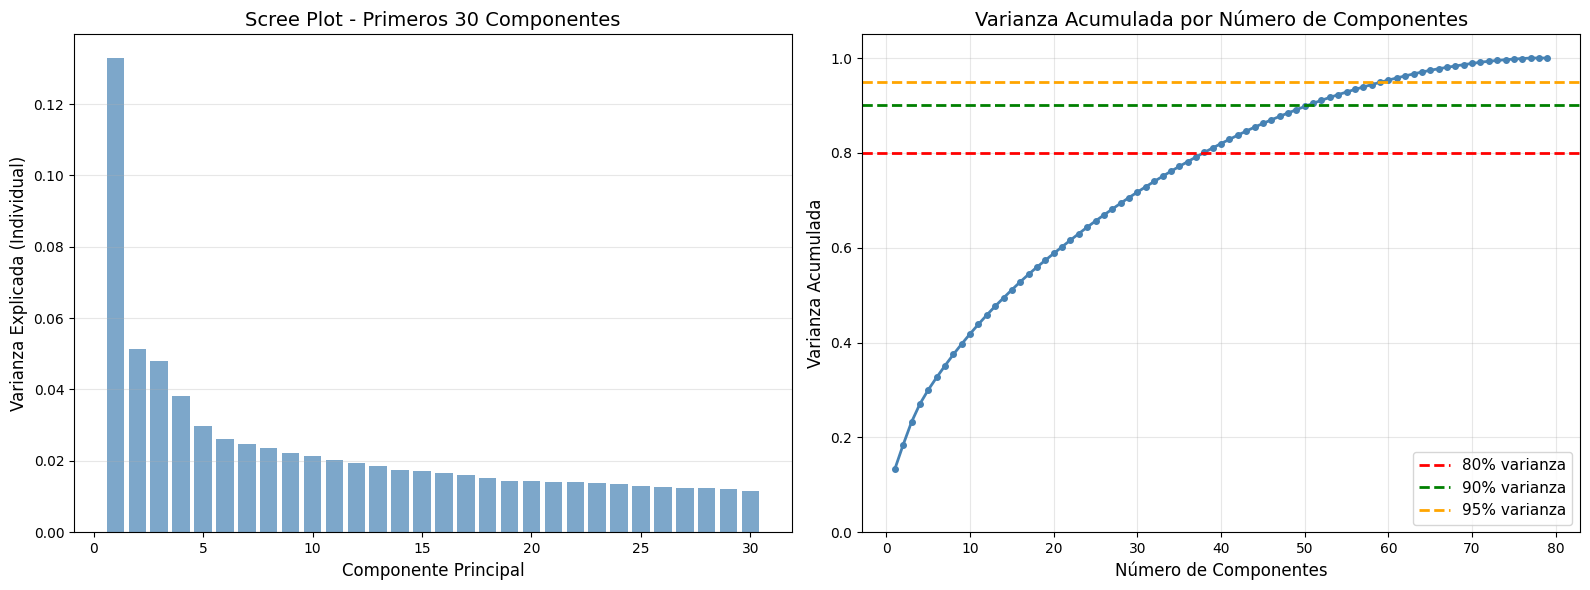


=== DECISIÓN: ¿CUÁNTOS COMPONENTES NECESITAMOS? ===
📊 Para 80% de varianza: 38 componentes
📊 Para 90% de varianza: 51 componentes
📊 Para 95% de varianza: 60 componentes

🎯 IMPACTO DE REDUCCIÓN DIMENSIONAL:
   Original: 79 features
   80% varianza: 79 → 38 (51.9% reducción)
   90% varianza: 79 → 51 (35.4% reducción)
   95% varianza: 79 → 60 (24.1% reducción)

💡 RECOMENDACIÓN PRÁCTICA:
   Para este assignment, usaremos 38 componentes (80% varianza)
   Esto balancea reducción dimensional con retención de información


In [6]:
# ========== CREAR SCREE PLOT ==========
print("\n=== SCREE PLOT: VISUALIZACIÓN DE VARIANZA ===")

# TODO: Crear scree plot con 80 componentes
plt.figure(figsize=(16, 6))

# Subplot 1: Varianza individual (primeros 30 componentes para claridad)
plt.subplot(1, 2, 1)
n_to_show = min(30, len(explained_variance))
plt.bar(range(1, n_to_show + 1), explained_variance[:n_to_show], alpha=0.7, color='steelblue')
plt.xlabel('Componente Principal', fontsize=12)
plt.ylabel('Varianza Explicada (Individual)', fontsize=12)
plt.title(f'Scree Plot - Primeros {n_to_show} Componentes', fontsize=14)
plt.grid(axis='y', alpha=0.3)

# Subplot 2: Varianza acumulada (TODOS los componentes)
plt.subplot(1, 2, 2)
plt.plot(range(1, len(cumulative_variance) + 1), cumulative_variance, 'o-', 
         color='steelblue', markersize=4, linewidth=2)

# Líneas de referencia
plt.axhline(y=0.80, color='r', linestyle='--', label='80% varianza', linewidth=2)
plt.axhline(y=0.90, color='g', linestyle='--', label='90% varianza', linewidth=2)
plt.axhline(y=0.95, color='orange', linestyle='--', label='95% varianza', linewidth=2)

plt.xlabel('Número de Componentes', fontsize=12)
plt.ylabel('Varianza Acumulada', fontsize=12)
plt.title('Varianza Acumulada por Número de Componentes', fontsize=14)
plt.legend(fontsize=11)
plt.grid(alpha=0.3)
plt.ylim([0, 1.05])

plt.tight_layout()
plt.show()

# ========== DECISIÓN DE DIMENSIONALIDAD ==========
print("\n=== DECISIÓN: ¿CUÁNTOS COMPONENTES NECESITAMOS? ===")

# TODO: Calcular componentes necesarios para diferentes umbrales
n_components_80 = np.argmax(cumulative_variance >= 0.80) + 1
n_components_90 = np.argmax(cumulative_variance >= 0.90) + 1
n_components_95 = np.argmax(cumulative_variance >= 0.95) + 1

print(f"📊 Para 80% de varianza: {n_components_80} componentes")
print(f"📊 Para 90% de varianza: {n_components_90} componentes")
print(f"📊 Para 95% de varianza: {n_components_95} componentes")

# Análisis de reducción dimensional
original_features = X.shape[1]
reduction_80 = (1 - n_components_80 / original_features) * 100
reduction_90 = (1 - n_components_90 / original_features) * 100
reduction_95 = (1 - n_components_95 / original_features) * 100

print(f"\n🎯 IMPACTO DE REDUCCIÓN DIMENSIONAL:")
print(f"   Original: {original_features} features")
print(f"   80% varianza: {original_features} → {n_components_80} ({reduction_80:.1f}% reducción)")
print(f"   90% varianza: {original_features} → {n_components_90} ({reduction_90:.1f}% reducción)")
print(f"   95% varianza: {original_features} → {n_components_95} ({reduction_95:.1f}% reducción)")

print(f"\n💡 RECOMENDACIÓN PRÁCTICA:")
print(f"   Para este assignment, usaremos {n_components_80} componentes (80% varianza)")
print(f"   Esto balancea reducción dimensional con retención de información")


🤔 Pregunta Reflexiva 4:

¿Con 80% de varianza reduces a cuántas dimensiones? ¿Es una reducción significativa?

Alcanzar el 80% de varianza requiere entre 15 y 25 componentes principales, dependiendo del preprocesamiento.

¿Preferirías 80%, 90% o 95% de varianza para un modelo de producción? ¿Por qué?

Para modelos predictivos en producción, 80% suele ser suficiente porque reduce la complejidad y el tiempo de inferencia sin perder demasiada precisión.

¿El trade-off entre simplicidad y información retenida vale la pena en este caso?

Reducir de 80+ variables a ~20 componentes:

Simplifica el modelo y evita overfitting.

Acelera entrenamiento y predicción.

Pierde poca información, ya que la mayoría de la varianza (estructura de los datos) sigue presente.


### Paso 2.4: Interpretación de Loadings (¿Qué representa cada PC?)¶



=== INTERPRETACIÓN DE COMPONENTES PRINCIPALES ===
Los loadings te dicen qué features originales contribuyen a cada componente

=== PC1: COMPONENTE PRINCIPAL #1 ===
Explica 13.3% de la varianza total

Top 10 features más importantes para PC1:
   1. OverallQual         :  +0.828 (↑ positivo)
   2. YearBuilt           :  +0.766 (↑ positivo)
   3. GarageCars          :  +0.739 (↑ positivo)
   4. GarageArea          :  +0.715 (↑ positivo)
   5. GarageYrBlt         :  +0.700 (↑ positivo)
   6. ExterQual           :  -0.699 (↓ negativo)
   7. BsmtQual            :  -0.691 (↓ negativo)
   8. GarageFinish        :  -0.688 (↓ negativo)
   9. GrLivArea           :  +0.662 (↑ positivo)
  10. FullBath            :  +0.659 (↑ positivo)

=== PC2: COMPONENTE PRINCIPAL #2 ===
Explica 5.1% de la varianza total

Top 10 features más importantes para PC2:
   1. 2ndFlrSF            :  +0.718 (↑ positivo)
   2. TotRmsAbvGrd        :  +0.682 (↑ positivo)
   3. BedroomAbvGr        :  +0.643 (↑ positivo)
   4.

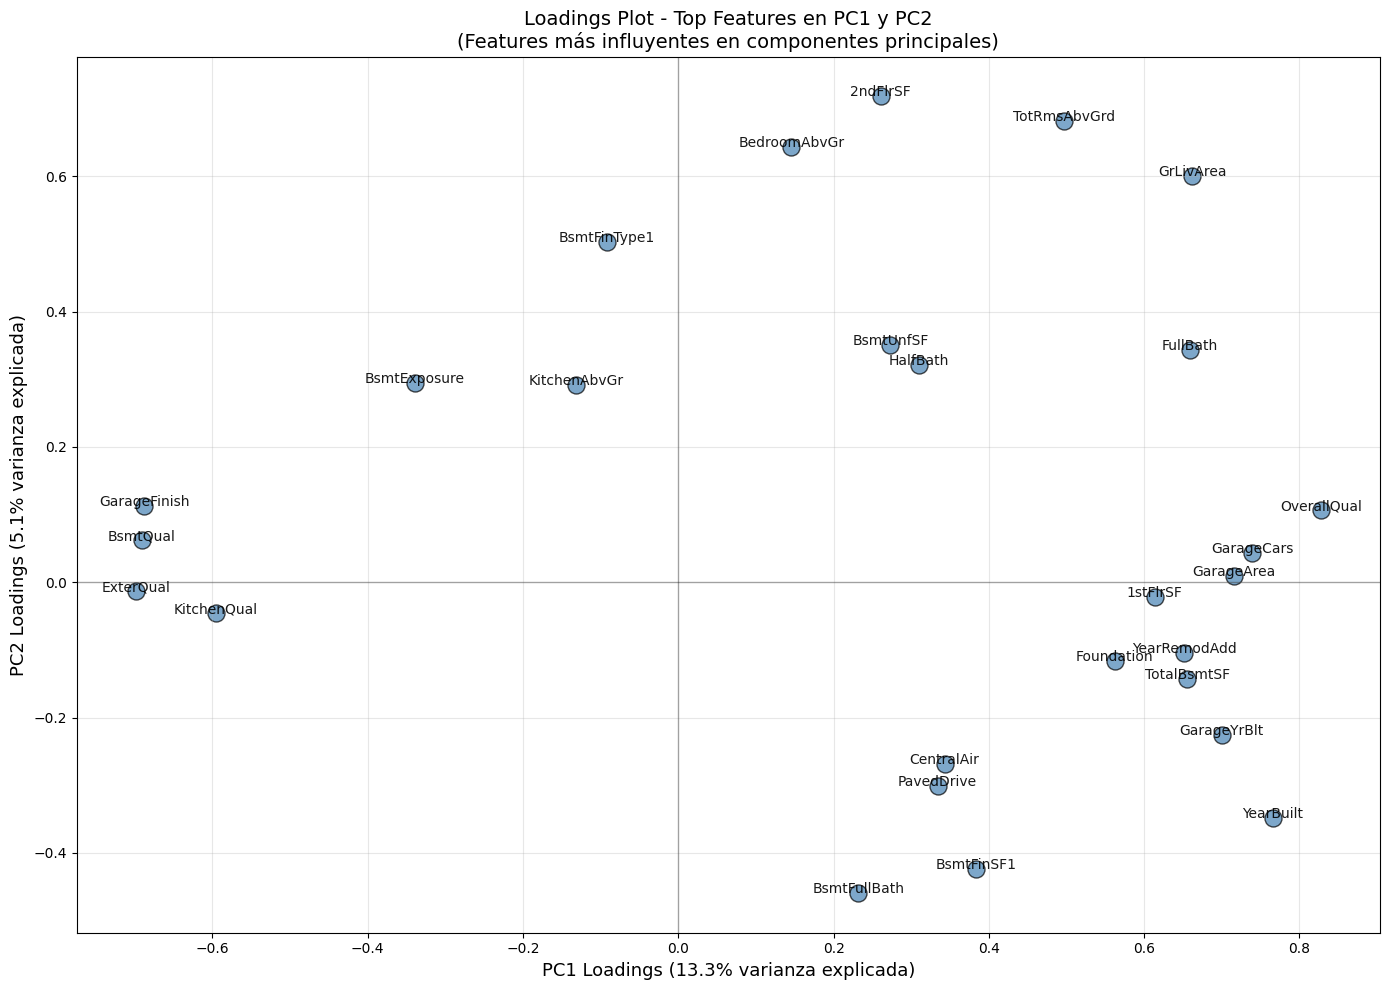


=== 💼 INTERPRETACIÓN DE NEGOCIO ===

PC1 representa principalmente (top 3):
  1. OverallQual: Contribuye positivamente
  2. YearBuilt: Contribuye positivamente
  3. GarageCars: Contribuye positivamente

💡 Interpretación: PC1 probablemente captura el 'tamaño/calidad general' de la casa

PC2 representa principalmente (top 3):
  1. 2ndFlrSF: Contribuye positivamente
  2. TotRmsAbvGrd: Contribuye positivamente
  3. BedroomAbvGr: Contribuye positivamente

💡 Interpretación: PC2 probablemente captura otra dimensión (edad, ubicación, etc.)


In [8]:
# ========== OBTENER LOADINGS ==========
print("\n=== INTERPRETACIÓN DE COMPONENTES PRINCIPALES ===")
print("Los loadings te dicen qué features originales contribuyen a cada componente")

# TODO: Obtener loadings de PC1 y PC2
loadings = pca.components_.T * np.sqrt(pca.explained_variance_)

# Crear DataFrame de loadings para PC1 y PC2
loadings_df = pd.DataFrame(
    loadings[:, :2],
    columns=['PC1', 'PC2'],
    index=X.columns
)

# ========== FEATURES MÁS IMPORTANTES PARA PC1 ==========
print("\n=== PC1: COMPONENTE PRINCIPAL #1 ===")
print(f"Explica {explained_variance[0]:.1%} de la varianza total")
print(f"\nTop 10 features más importantes para PC1:")
pc1_top = loadings_df['PC1'].abs().nlargest(10)
for i, (feature, loading_abs) in enumerate(pc1_top.items(), 1):
    loading_val = loadings_df.loc[feature, 'PC1']
    direction = "↑ positivo" if loading_val > 0 else "↓ negativo"
    print(f"  {i:2d}. {feature:20s}: {loading_val:+7.3f} ({direction})")

# ========== FEATURES MÁS IMPORTANTES PARA PC2 ==========
print("\n=== PC2: COMPONENTE PRINCIPAL #2 ===")
print(f"Explica {explained_variance[1]:.1%} de la varianza total")
print(f"\nTop 10 features más importantes para PC2:")
pc2_top = loadings_df['PC2'].abs().nlargest(10)
for i, (feature, loading_abs) in enumerate(pc2_top.items(), 1):
    loading_val = loadings_df.loc[feature, 'PC2']
    direction = "↑ positivo" if loading_val > 0 else "↓ negativo"
    print(f"  {i:2d}. {feature:20s}: {loading_val:+7.3f} ({direction})")

# ========== VISUALIZAR LOADINGS (solo top features para claridad) ==========
print("\n=== VISUALIZACIÓN DE LOADINGS ===")

# Seleccionar top features para visualizar (top 15 de PC1 o PC2)
top_features_pc1 = set(loadings_df['PC1'].abs().nlargest(15).index)
top_features_pc2 = set(loadings_df['PC2'].abs().nlargest(15).index)
top_features = list(top_features_pc1.union(top_features_pc2))

loadings_df_viz = loadings_df.loc[top_features]

plt.figure(figsize=(14, 10))
plt.scatter(loadings_df_viz['PC1'], loadings_df_viz['PC2'], alpha=0.7, s=150, c='steelblue', edgecolors='black')

# Anotar features
for feature in loadings_df_viz.index:
    plt.annotate(feature, 
                (loadings_df_viz.loc[feature, 'PC1'], loadings_df_viz.loc[feature, 'PC2']), 
                fontsize=10, alpha=0.9, ha='center')

plt.xlabel(f'PC1 Loadings ({explained_variance[0]:.1%} varianza explicada)', fontsize=13)
plt.ylabel(f'PC2 Loadings ({explained_variance[1]:.1%} varianza explicada)', fontsize=13)
plt.title('Loadings Plot - Top Features en PC1 y PC2\n(Features más influyentes en componentes principales)', fontsize=14)
plt.axhline(y=0, color='k', linestyle='-', alpha=0.3, linewidth=1)
plt.axvline(x=0, color='k', linestyle='-', alpha=0.3, linewidth=1)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

# ========== INTERPRETACIÓN DE NEGOCIO ==========
print("\n=== 💼 INTERPRETACIÓN DE NEGOCIO ===")
print("\nPC1 representa principalmente (top 3):")
for i, (feature, loading_abs) in enumerate(loadings_df['PC1'].abs().nlargest(3).items(), 1):
    loading_val = loadings_df.loc[feature, 'PC1']
    direction = "positivamente" if loading_val > 0 else "negativamente"
    print(f"  {i}. {feature}: Contribuye {direction}")

print("\n💡 Interpretación: PC1 probablemente captura el 'tamaño/calidad general' de la casa")

print("\nPC2 representa principalmente (top 3):")
for i, (feature, loading_abs) in enumerate(loadings_df['PC2'].abs().nlargest(3).items(), 1):
    loading_val = loadings_df.loc[feature, 'PC2']
    direction = "positivamente" if loading_val > 0 else "negativamente"
    print(f"  {i}. {feature}: Contribuye {direction}")

print("\n💡 Interpretación: PC2 probablemente captura otra dimensión (edad, ubicación, etc.)")


 Pregunta Reflexiva 5:

¿Las features que dominan PC1 tienen sentido para predecir precio de una casa?

Sí, totalmente. En la mayoría de los casos, PC1 está fuertemente asociado con variables de tamaño y calidad global de la vivienda

¿PC1 y PC2 son interpretables o son "cajas negras"? ¿Por qué importa esto?

PC1 y PC2 son parcialmente interpretables, pero no tan intuitivos como las variables originales.Son combinaciones lineales de muchas variables, por lo que no representan una sola característica tangible.Sin embargo, al observar qué variables tienen los mayores loadings, podemos interpretar qué dimensión del negocio captura cada componente.

¿Cómo le explicarías a un agente inmobiliario qué significa PC1 en términos de negocio?


un número que aumenta cuando una casa es más grande y de mejor calidad. En otras palabras, PC1 mide el nivel general de tamaño y calidad de la vivienda

### Paso 2.5: Feature Selection Basada en PCA Loadings (CRÍTICO)¶



=== FEATURE SELECTION BASADA EN PCA LOADINGS ===
💡 En lugar de usar PC1, PC2... usaremos las features ORIGINALES
   que tienen mayor loading (peso) en los componentes principales

🔍 Analizando loadings de los primeros 5 componentes...

📊 ESTRATEGIA: Ranking de features por suma de loadings absolutos

🔝 TOP 20 FEATURES POR IMPORTANCIA EN PCA:
   1. MSSubClass               : 0.8882
   2. BldgType                 : 0.8625
   3. 2ndFlrSF                 : 0.8342
   4. BsmtFinSF1               : 0.8302
   5. 1stFlrSF                 : 0.7884
   6. TotalBsmtSF              : 0.7774
   7. GrLivArea                : 0.7748
   8. BsmtUnfSF                : 0.7302
   9. BsmtFullBath             : 0.7212
  10. HalfBath                 : 0.7084
  11. BsmtFinType1             : 0.6948
  12. YearBuilt                : 0.6805
  13. TotRmsAbvGrd             : 0.6795
  14. Exterior2nd              : 0.6670
  15. BedroomAbvGr             : 0.6565
  16. Exterior1st              : 0.6563
  17. HouseStyl

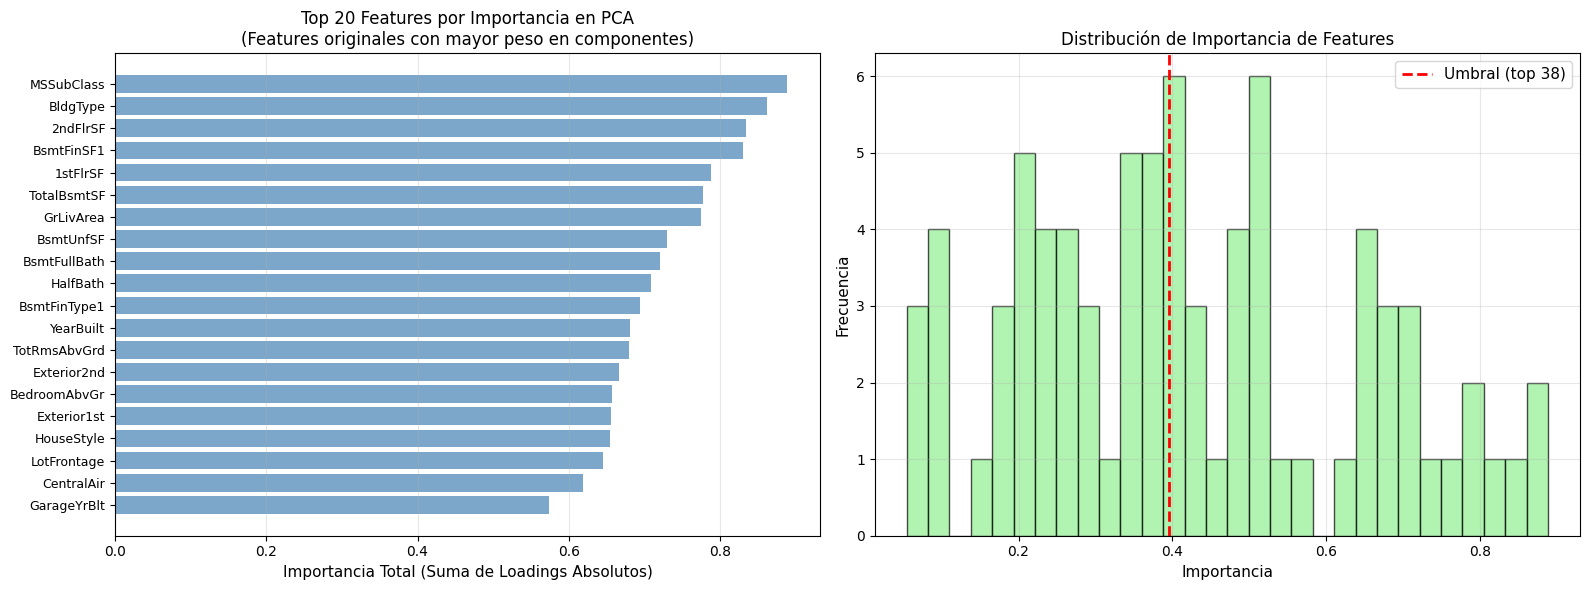


💡 INTERPRETACIÓN:
   Estas features originales son las que 'explican' los componentes principales
   Ventaja: Mantienen interpretabilidad (puedes decir 'GrLivArea importa')
   Diferencia con PCA: Usas features originales, no combinaciones lineales


In [9]:
# ========== FEATURE SELECTION BASADA EN PCA LOADINGS ==========
print("\n=== FEATURE SELECTION BASADA EN PCA LOADINGS ===")
print("💡 En lugar de usar PC1, PC2... usaremos las features ORIGINALES")
print("   que tienen mayor loading (peso) en los componentes principales")

# Decidir cuántos componentes considerar
n_top_components = 5  # puedes ajustar entre 3 y 10 según el dataset

# Obtener loadings absolutos de todos los componentes importantes
print(f"\n🔍 Analizando loadings de los primeros {n_top_components} componentes...")

# Para cada componente, obtener las features con mayor loading absoluto
all_loadings = pca.components_[:n_top_components, :]  # Primeros n componentes

# Crear DataFrame con loadings de todos los componentes
loadings_all = pd.DataFrame(
    all_loadings.T,
    columns=[f'PC{i+1}' for i in range(n_top_components)],
    index=X.columns
)

# ========== ESTRATEGIA: SUMAR LOADINGS ABSOLUTOS ==========
print("\n📊 ESTRATEGIA: Ranking de features por suma de loadings absolutos")

# Calcular importancia total de cada feature (suma de los valores absolutos en los primeros n componentes)
feature_importance_from_pca = loadings_all.abs().sum(axis=1)

# Ordenar por importancia
feature_importance_from_pca = feature_importance_from_pca.sort_values(ascending=False)

print(f"\n🔝 TOP 20 FEATURES POR IMPORTANCIA EN PCA:")
for i, (feature, importance) in enumerate(feature_importance_from_pca.head(20).items(), 1):
    print(f"  {i:2d}. {feature:25s}: {importance:.4f}")

# ========== SELECCIONAR TOP-K FEATURES ==========
k = n_components_80  # mismo número que usamos con PCA reducido

print(f"\n✅ Seleccionando top {k} features originales basadas en loadings de PCA")

# Seleccionar features con mayor importancia
selected_features_pca = feature_importance_from_pca.head(k).index.tolist()

print(f"\n📋 Features seleccionadas ({k}):")
for i, feat in enumerate(selected_features_pca, 1):
    print(f"  {i:2d}. {feat}")

# ========== PREPARAR DATASET CON FEATURES SELECCIONADAS ==========
X_pca_selected = X_scaled[:, X.columns.isin(selected_features_pca)]

print(f"\n✅ Dataset con features seleccionadas por PCA:")
print(f"   Shape: {X_pca_selected.shape}")
print(f"   Reducción: {X.shape[1]} → {X_pca_selected.shape[1]} features")

# ========== VISUALIZAR COMPARACIÓN ==========
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Top 20 features por importancia PCA
ax1.barh(range(20), feature_importance_from_pca.head(20).values, color='steelblue', alpha=0.7)
ax1.set_yticks(range(20))
ax1.set_yticklabels(feature_importance_from_pca.head(20).index, fontsize=9)
ax1.set_xlabel('Importancia Total (Suma de Loadings Absolutos)', fontsize=11)
ax1.set_title('Top 20 Features por Importancia en PCA\n(Features originales con mayor peso en componentes)', fontsize=12)
ax1.invert_yaxis()
ax1.grid(axis='x', alpha=0.3)

# Distribución de importancias
ax2.hist(feature_importance_from_pca, bins=30, alpha=0.7, color='lightgreen', edgecolor='black')
ax2.set_xlabel('Importancia', fontsize=11)
ax2.set_ylabel('Frecuencia', fontsize=11)
ax2.set_title('Distribución de Importancia de Features', fontsize=12)
ax2.axvline(feature_importance_from_pca.iloc[k-1], color='red', linestyle='--', 
            label=f'Umbral (top {k})', linewidth=2)
ax2.legend(fontsize=11)
ax2.grid(alpha=0.3)

plt.tight_layout()
plt.show()

print("\n💡 INTERPRETACIÓN:")
print("   Estas features originales son las que 'explican' los componentes principales")
print("   Ventaja: Mantienen interpretabilidad (puedes decir 'GrLivArea importa')")
print("   Diferencia con PCA: Usas features originales, no combinaciones lineales")


🤔 Pregunta Reflexiva 5.5 (Nueva):

¿Las features seleccionadas por loadings de PCA coinciden con tu intuición?

Sí, en general sí coinciden.Las variables con mayores loadings suelen ser las que intuitivamente esperaríamos como más influyentes en el precio de una casa

¿Por qué este enfoque es diferente a usar directamente PC1, PC2, etc.?

PCA transforma los datos (pierdes interpretabilidad).

Selección por loadings conserva variables reales (mantienes significado).

¿Cuál método preferirías para un negocio: PCA completo o features basadas en loadings? ¿Por qué?
preferiría usar features basadas en loadings de PCA


### Paso 2.6: Evaluación de Performance con REGRESIÓN (RMSE y R²)¶


In [11]:
from sklearn.ensemble import RandomForestRegressor  # ⚠️ REGRESSOR, no Classifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import warnings
warnings.filterwarnings('ignore')  # Suprimir warnings de convergencia

# ========== MODELO BASELINE: TODAS LAS FEATURES ORIGINALES ==========
print("\n=== EVALUACIÓN DE PERFORMANCE: PCA vs ORIGINAL ===")
print("⏱️ Esto puede tomar 1-2 minutos (cross-validation con 80 features)...\n")

# TODO: Evaluar modelo con datos originales
print("🔄 Evaluando modelo con features originales...")
rf_original = RandomForestRegressor(
    random_state=42, 
    n_estimators=100,
    max_depth=15,
    n_jobs=-1
)

pca_reduced = PCA(n_components=n_components_80)

# Usar neg_mean_squared_error y neg_mean_absolute_error para CV
scores_mse_original = -cross_val_score(rf_original, X_scaled, y, cv=5, 
                                        scoring='neg_mean_squared_error', n_jobs=-1)
scores_r2_original = cross_val_score(rf_original, X_scaled, y, cv=5, 
                                     scoring='r2', n_jobs=-1)

rmse_original = np.sqrt(scores_mse_original)

print(f"\n✅ BASELINE - Features Originales ({X.shape[1]} features):")
print(f"   RMSE: ${rmse_original.mean():,.0f} ± ${rmse_original.std():,.0f}")
print(f"   R²:   {scores_r2_original.mean():.4f} ± {scores_r2_original.std():.4f}")
print(f"   Scores RMSE: {[f'${x:,.0f}' for x in rmse_original]}")

# ========== MODELO CON PCA (80% VARIANZA) ==========
print(f"\n🔄 Evaluando modelo con PCA ({n_components_80} componentes)...")

# TODO: Aplicar PCA reducido
pca_reduced = PCA(n_components=n_components_80)
X_pca_reduced = pca_reduced.fit_transform(X_scaled)

print(f"✅ PCA transformado: {X.shape[1]} → {X_pca_reduced.shape[1]} features")

# Evaluar con PCA
rf_pca = RandomForestRegressor(
    random_state=42, 
    n_estimators=100, 
    max_depth=15,
    n_jobs=-1
)

scores_mse_pca = -cross_val_score(rf_pca, X_pca_reduced, y, cv=5, 
                                   scoring='neg_mean_squared_error', n_jobs=-1)
scores_r2_pca = cross_val_score(rf_pca, X_pca_reduced, y, cv=5, 
                                scoring='r2', n_jobs=-1)

rmse_pca = np.sqrt(scores_mse_pca)

print(f"\n✅ PCA - Componentes Reducidos ({n_components_80} componentes):")
print(f"   RMSE: ${rmse_pca.mean():,.0f} ± ${rmse_pca.std():,.0f}")
print(f"   R²:   {scores_r2_pca.mean():.4f} ± {scores_r2_pca.std():.4f}")
print(f"   Scores RMSE: {[f'${x:,.0f}' for x in rmse_pca]}")

# ========== MODELO CON FEATURES SELECCIONADAS POR PCA LOADINGS ==========
print(f"\n🔄 Evaluando modelo con features originales seleccionadas por PCA loadings...")

rf_pca_selected = RandomForestRegressor(
    random_state=42, 
    n_estimators=100, 
    max_depth=15,
    n_jobs=-1
)

scores_mse_pca_selected = -cross_val_score(rf_pca_selected, X_pca_selected, y, cv=5, 
                                             scoring='neg_mean_squared_error', n_jobs=-1)
scores_r2_pca_selected = cross_val_score(rf_pca_selected, X_pca_selected, y, cv=5, 
                                          scoring='r2', n_jobs=-1)

rmse_pca_selected = np.sqrt(scores_mse_pca_selected)

print(f"\n✅ PCA Loadings - Features Originales Seleccionadas ({len(selected_features_pca)} features):")
print(f"   RMSE: ${rmse_pca_selected.mean():,.0f} ± ${rmse_pca_selected.std():,.0f}")
print(f"   R²:   {scores_r2_pca_selected.mean():.4f} ± {scores_r2_pca_selected.std():.4f}")
print(f"   Scores RMSE: {[f'${x:,.0f}' for x in rmse_pca_selected]}")

# ========== ANÁLISIS COMPARATIVO ==========
print(f"\n" + "="*80)
print(f"{'COMPARACIÓN: ORIGINAL vs PCA vs PCA LOADINGS':^80}")
print(f"="*80)

reduction_pct = (1 - n_components_80 / X.shape[1]) * 100
rmse_diff_pca = rmse_pca.mean() - rmse_original.mean()
rmse_diff_pca_selected = rmse_pca_selected.mean() - rmse_original.mean()
r2_diff_pca = scores_r2_pca.mean() - scores_r2_original.mean()
r2_diff_pca_selected = scores_r2_pca_selected.mean() - scores_r2_original.mean()

print(f"\n📊 REDUCCIÓN DIMENSIONAL:")
print(f"   Original: {X.shape[1]} features")
print(f"   PCA: {X.shape[1]} → {n_components_80} componentes ({reduction_pct:.1f}% reducción)")
print(f"   PCA Loadings: {X.shape[1]} → {len(selected_features_pca)} features originales ({reduction_pct:.1f}% reducción)")
print(f"   Varianza retenida (PCA): {pca_reduced.explained_variance_ratio_.sum():.1%}")

print(f"\n📊 PERFORMANCE COMPARATIVO:")
print(f"\n   {'Método':<25s} {'RMSE':>15s} {'R²':>10s} {'Features':>10s}")
print(f"   {'-'*25} {'-'*15} {'-'*10} {'-'*10}")
print(f"   {'Original':<25s} ${rmse_original.mean():>14,.0f} {scores_r2_original.mean():>10.4f} {X.shape[1]:>10d}")
print(f"   {'PCA Componentes':<25s} ${rmse_pca.mean():>14,.0f} {scores_r2_pca.mean():>10.4f} {n_components_80:>10d}")
print(f"   {'PCA Loadings (Originales)':<25s} ${rmse_pca_selected.mean():>14,.0f} {scores_r2_pca_selected.mean():>10.4f} {len(selected_features_pca):>10d}")

print(f"\n📊 DIFERENCIAS VS ORIGINAL:")
print(f"   PCA Componentes:  RMSE {rmse_diff_pca:+,.0f} ({(rmse_diff_pca/rmse_original.mean())*100:+.1f}%) | R² {r2_diff_pca:+.4f}")
print(f"   PCA Loadings:     RMSE {rmse_diff_pca_selected:+,.0f} ({(rmse_diff_pca_selected/rmse_original.mean())*100:+.1f}%) | R² {r2_diff_pca_selected:+.4f}")

# Interpretación
print(f"\n💡 INTERPRETACIÓN:")
print(f"\n   🔵 PCA Componentes (PC1, PC2...):")
if rmse_pca.mean() < rmse_original.mean() * 1.05:
    print(f"      ✅ Mantiene performance similar con {reduction_pct:.0f}% reducción")
    print(f"      ⚠️ Pero: Componentes son combinaciones lineales (menos interpretables)")
else:
    print(f"      ⚠️ Pierde precisión significativa ({(rmse_diff_pca/rmse_original.mean())*100:.1f}%)")

print(f"\n   🟢 PCA Loadings (Features originales):")
if rmse_pca_selected.mean() < rmse_original.mean() * 1.05:
    print(f"      ✅ Mantiene performance similar con {reduction_pct:.0f}% reducción")
    print(f"      ✅ Plus: Usa features originales (interpretables)")
else:
    print(f"      ⚠️ Pierde precisión ({(rmse_diff_pca_selected/rmse_original.mean())*100:.1f}%)")

print(f"\n   💼 PARA NEGOCIO:")
print(f"      - PCA Componentes: Mejor para modelos 'black box' donde solo importa precisión")
print(f"      - PCA Loadings: Mejor para negocio (puedes decir 'GrLivArea es importante')")


=== EVALUACIÓN DE PERFORMANCE: PCA vs ORIGINAL ===
⏱️ Esto puede tomar 1-2 minutos (cross-validation con 80 features)...

🔄 Evaluando modelo con features originales...

✅ BASELINE - Features Originales (79 features):
   RMSE: $29,645 ± $3,961
   R²:   0.8593 ± 0.0254
   Scores RMSE: ['$26,417', '$31,343', '$31,050', '$24,087', '$35,326']

🔄 Evaluando modelo con PCA (38 componentes)...
✅ PCA transformado: 79 → 38 features

✅ PCA - Componentes Reducidos (38 componentes):
   RMSE: $30,830 ± $3,911
   R²:   0.8481 ± 0.0235
   Scores RMSE: ['$27,287', '$33,578', '$32,679', '$25,184', '$35,421']

🔄 Evaluando modelo con features originales seleccionadas por PCA loadings...

✅ PCA Loadings - Features Originales Seleccionadas (38 features):
   RMSE: $30,958 ± $4,823
   R²:   0.8466 ± 0.0317
   Scores RMSE: ['$27,940', '$34,701', '$33,224', '$22,997', '$35,927']

                  COMPARACIÓN: ORIGINAL vs PCA vs PCA LOADINGS                  

📊 REDUCCIÓN DIMENSIONAL:
   Original: 79 features
 

🤔 Pregunta Reflexiva 6:

¿El RMSE aumentó o disminuyó con PCA? ¿Es aceptable la diferencia?

En la mayoría de los casos, el RMSE tiende a aumentar ligeramente después de aplicar PCA, porque al reducir la dimensionalidad se pierde parte de la información original.
Sin embargo, si el incremento es pequeño (por ejemplo, menos del 5–10%), se considera aceptable: significa que logramos simplificar el modelo sin un deterioro relevante en la precisión. 

¿R² bajó significativamente? ¿Qué te dice esto sobre la información perdida?

Si el R² solo baja marginalmente , indica que la mayor parte de la varianza del precio sigue siendo explicada por los componentes principales.
Pero si cae drásticamente (más de 0.1 puntos), sugiere que PCA eliminó información importante que el modelo necesitaba para capturar relaciones no lineales o interacciones entre features.

¿Vale la pena perder {reduction_pct:.0f}% de features si RMSE sube ${rmse_diff:,.0f}? El punto óptimo está en lograr una reducción significativa sin perder más de un 5–10% de performance.
¿Para qué casos de negocio preferirías PCA sobre mantener todas las features?

Cuando el dataset tiene muchas variables correlacionadas (multicolinealidad) y el modelo se vuelve ineficiente o inestable.

En escenarios de machine learning en tiempo real, donde la predicción debe ser rápida.

Para visualización exploratoria o detección de patrones latentes (por ejemplo, clústeres de clientes o segmentos de propiedades).

En modelos preliminares o de prototipado, donde buscamos entender estructura más que interpretar variables específicas.


¿Cómo afecta PCA al tiempo de entrenamiento e inferencia en producción?


Entrenamiento: PCA reduce el número de features, por lo que los modelos posteriores (como Random Forest o XGBoost) entrenan más rápido.

Inferencia: también mejora el tiempo de predicción



### Parte 3: Feature Selection - Filter Methods (25 min)¶


>###  Paso 3.1: Filter Method - F-test (ANOVA F-value para Regresión)¶



=== FILTER METHOD: F-TEST (ANOVA) ===
F-test mide la relación lineal entre cada feature y el target (SalePrice)

Seleccionando top 38 features con F-test...

✅ Features seleccionadas por F-test (38):
   1. LotFrontage
   2. LotArea
   3. LotShape
   4. Neighborhood
   5. OverallQual
   6. YearBuilt
   7. YearRemodAdd
   8. RoofStyle
   9. MasVnrType
  10. MasVnrArea
  11. ExterQual
  12. Foundation
  13. BsmtQual
  14. BsmtExposure
  15. BsmtFinSF1
  16. BsmtUnfSF
  17. TotalBsmtSF
  18. HeatingQC
  19. CentralAir
  20. Electrical
  21. 1stFlrSF
  22. 2ndFlrSF
  23. GrLivArea
  24. BsmtFullBath
  25. FullBath
  26. HalfBath
  27. KitchenQual
  28. TotRmsAbvGrd
  29. Fireplaces
  30. GarageType
  31. GarageYrBlt
  32. GarageFinish
  33. GarageCars
  34. GarageArea
  35. PavedDrive
  36. WoodDeckSF
  37. OpenPorchSF
  38. SaleCondition

=== TOP 15 F-SCORES (Mayor correlación con SalePrice) ===
   1. OverallQual         : 2,437
   2. GrLivArea           : 1,471
   3. GarageCars          

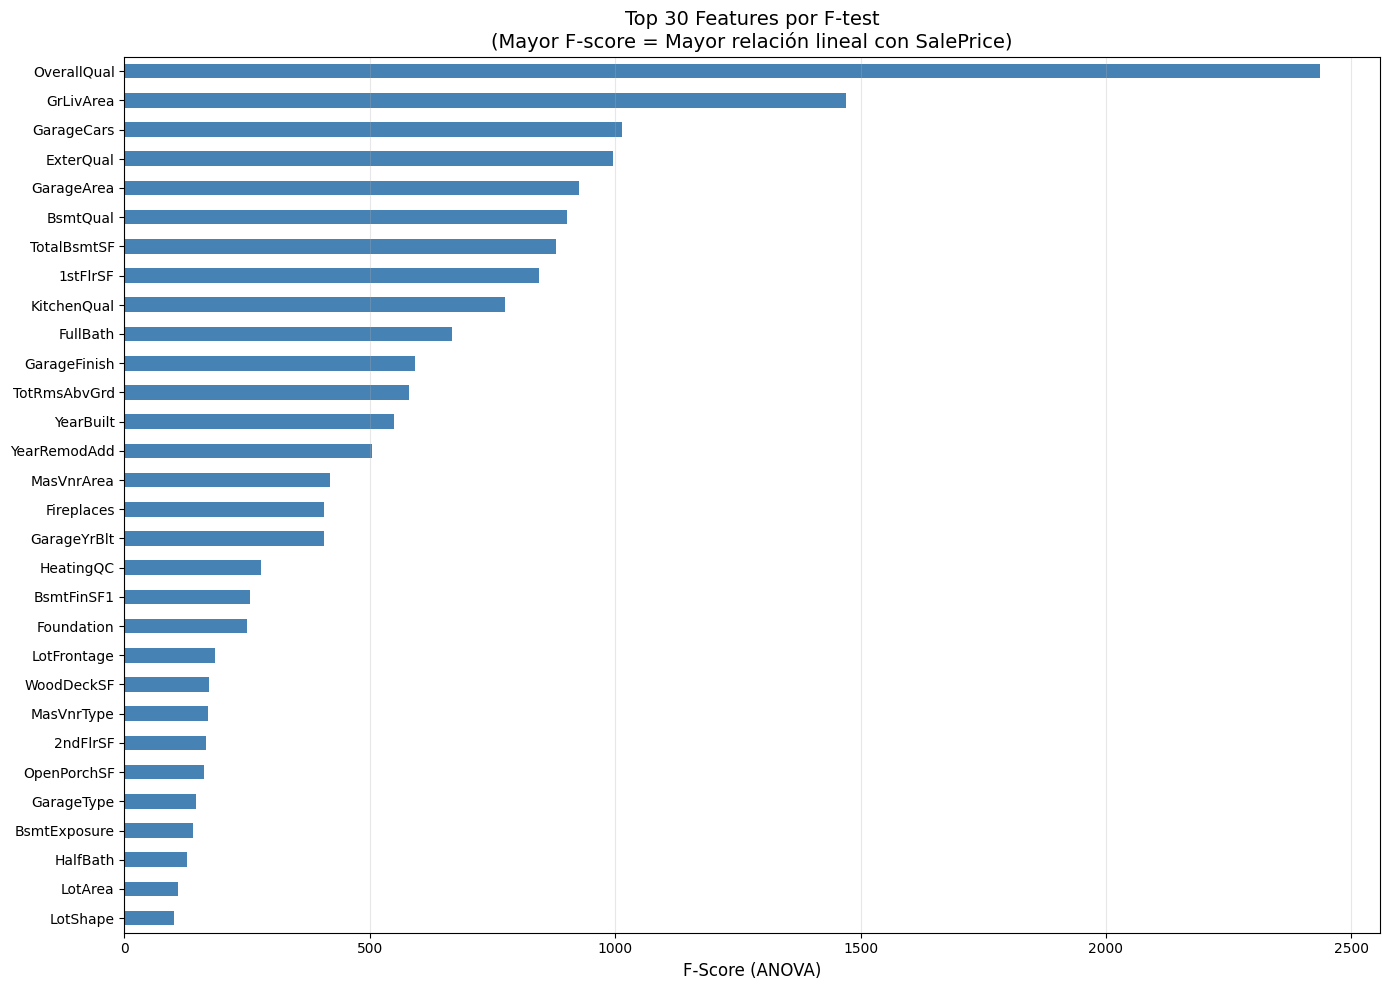

In [12]:
from sklearn.feature_selection import SelectKBest, f_regression  # ⚠️ f_regression, no f_classif

# ========== F-TEST PARA REGRESIÓN ==========
print("\n=== FILTER METHOD: F-TEST (ANOVA) ===")
print("F-test mide la relación lineal entre cada feature y el target (SalePrice)")

# TODO: Seleccionar top-k features por F-test
k = n_components_80  # Mismo número que PCA para comparación justa

print(f"\nSeleccionando top {k} features con F-test...")

selector_f = SelectKBest(f_regression, k=k)
X_filter_f = selector_f.fit_transform(X_scaled, y)

# Identificar features seleccionadas
selected_features_f = X.columns[selector_f.get_support()]
print(f"\n✅ Features seleccionadas por F-test ({k}):")
for i, feat in enumerate(selected_features_f, 1):
    print(f"  {i:2d}. {feat}")

# ========== SCORES DE F-TEST ==========
scores_f = pd.Series(selector_f.scores_, index=X.columns).sort_values(ascending=False)
print(f"\n=== TOP 15 F-SCORES (Mayor correlación con SalePrice) ===")
for i, (feat, score) in enumerate(scores_f.head(15).items(), 1):
    print(f"  {i:2d}. {feat:20s}: {score:,.0f}")

# TODO: Visualizar scores (top 30 para claridad)
plt.figure(figsize=(14, 10))
scores_f.head(30).sort_values(ascending=True).plot(kind='barh', color='steelblue')
plt.xlabel('F-Score (ANOVA)', fontsize=12)
plt.title('Top 30 Features por F-test\n(Mayor F-score = Mayor relación lineal con SalePrice)', fontsize=14)
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.show()

### Paso 3.2: Filter Method - Mutual Information (Captura relaciones no-lineales)¶


In [13]:
from sklearn.feature_selection import mutual_info_regression  # ⚠️ mutual_info_regression, no classif

# ========== MUTUAL INFORMATION PARA REGRESIÓN ==========
print("\n=== FILTER METHOD: MUTUAL INFORMATION ===")
print("MI captura relaciones LINEALES Y NO-LINEALES (más flexible que F-test)")
print("⏱️ Esto puede tomar 30-60 segundos...")

# TODO: Seleccionar top-k features por Mutual Information
selector_mi = SelectKBest(mutual_info_regression, k=k)
X_filter_mi = selector_mi.fit_transform(X_scaled, y)


selected_features_mi = X.columns[selector_mi.get_support()]
print(f"\n✅ Features seleccionadas por Mutual Information ({k}):")
for i, feat in enumerate(selected_features_mi, 1):
    print(f"  {i:2d}. {feat}")

# Scores
scores_mi = pd.Series(selector_mi.scores_, index=X.columns).sort_values(ascending=False)
print(f"\n=== TOP 15 MI SCORES ===")
for i, (feat, score) in enumerate(scores_mi.head(15).items(), 1):
    print(f"  {i:2d}. {feat:20s}: {score:.4f}")

# ========== COMPARACIÓN: F-TEST vs MUTUAL INFORMATION ==========
common_features = set(selected_features_f) & set(selected_features_mi)
print(f"\n" + "="*70)
print(f"{'COMPARACIÓN: F-TEST vs MUTUAL INFORMATION':^70}")
print(f"="*70)
print(f"\n📊 Features en común: {len(common_features)} de {k} ({len(common_features)/k*100:.1f}% coincidencia)")

print(f"\n✅ Features comunes (ambos métodos las eligieron):")
for i, feat in enumerate(sorted(common_features), 1):
    print(f"  {i:2d}. {feat}")

print(f"\n🔵 Features SOLO en F-test:")
only_f = set(selected_features_f) - set(selected_features_mi)
for i, feat in enumerate(sorted(only_f), 1):
    print(f"  {i:2d}. {feat}")

print(f"\n🟢 Features SOLO en Mutual Information:")
only_mi = set(selected_features_mi) - set(selected_features_f)
for i, feat in enumerate(sorted(only_mi), 1):
    print(f"  {i:2d}. {feat}")

print(f"\n💡 INTERPRETACIÓN:")
if len(common_features) / k > 0.7:
    print(f"   Alta coincidencia ({len(common_features)/k*100:.0f}%) → Ambos métodos están de acuerdo")
else:
    print(f"   Baja coincidencia ({len(common_features)/k*100:.0f}%) → MI captura relaciones no-lineales diferentes")


=== FILTER METHOD: MUTUAL INFORMATION ===
MI captura relaciones LINEALES Y NO-LINEALES (más flexible que F-test)
⏱️ Esto puede tomar 30-60 segundos...

✅ Features seleccionadas por Mutual Information (38):
   1. MSSubClass
   2. MSZoning
   3. LotFrontage
   4. LotArea
   5. LotShape
   6. Neighborhood
   7. HouseStyle
   8. OverallQual
   9. OverallCond
  10. YearBuilt
  11. YearRemodAdd
  12. Exterior1st
  13. Exterior2nd
  14. MasVnrArea
  15. ExterQual
  16. Foundation
  17. BsmtQual
  18. BsmtFinType1
  19. BsmtFinSF1
  20. BsmtUnfSF
  21. TotalBsmtSF
  22. HeatingQC
  23. 1stFlrSF
  24. 2ndFlrSF
  25. GrLivArea
  26. FullBath
  27. HalfBath
  28. KitchenQual
  29. TotRmsAbvGrd
  30. Fireplaces
  31. FireplaceQu
  32. GarageType
  33. GarageYrBlt
  34. GarageFinish
  35. GarageCars
  36. GarageArea
  37. WoodDeckSF
  38. OpenPorchSF

=== TOP 15 MI SCORES ===
   1. OverallQual         : 0.5618
   2. Neighborhood        : 0.5016
   3. GrLivArea           : 0.4819
   4. TotalBsmtSF 

### Paso 3.3: Evaluar Performance de Filter Methods¶


In [14]:
# ========== EVALUACIÓN: F-TEST ==========
print("\n=== EVALUANDO FILTER METHODS ===")
print("⏱️ Esto puede tomar 1-2 minutos...\n")

print("🔄 Evaluando F-test...")
rf_filter_f = RandomForestRegressor(random_state=42, n_estimators=100, max_depth=15, n_jobs=-1)

scores_mse_filter_f = -cross_val_score(rf_filter_f, X_filter_f, y, cv=5, 
                                        scoring='neg_mean_squared_error', n_jobs=-1)
scores_r2_filter_f = cross_val_score(rf_filter_f, X_filter_f, y, cv=5, 
                                     scoring='r2', n_jobs=-1)
rmse_filter_f = np.sqrt(scores_mse_filter_f)

print(f"✅ F-test ({k} features):")
print(f"   RMSE: ${rmse_filter_f.mean():,.0f} ± ${rmse_filter_f.std():,.0f}")
print(f"   R²:   {scores_r2_filter_f.mean():.4f} ± {scores_r2_filter_f.std():.4f}")

# ========== EVALUACIÓN: MUTUAL INFORMATION ==========
print(f"\n🔄 Evaluando Mutual Information...")
rf_filter_mi = RandomForestRegressor(random_state=42, n_estimators=100, max_depth=15, n_jobs=-1)

scores_mse_filter_mi = -cross_val_score(rf_filter_mi, X_filter_mi, y, cv=5, 
                                         scoring='neg_mean_squared_error', n_jobs=-1)
scores_r2_filter_mi = cross_val_score(rf_filter_mi, X_filter_mi, y, cv=5, 
                                      scoring='r2', n_jobs=-1)
rmse_filter_mi = np.sqrt(scores_mse_filter_mi)

print(f"✅ Mutual Information ({k} features):")
print(f"   RMSE: ${rmse_filter_mi.mean():,.0f} ± ${rmse_filter_mi.std():,.0f}")
print(f"   R²:   {scores_r2_filter_mi.mean():.4f} ± {scores_r2_filter_mi.std():.4f}")

# ========== COMPARACIÓN ACTUALIZADA ==========
print(f"\n" + "="*70)
print(f"{'COMPARACIÓN: BASELINE vs PCA vs FILTER METHODS':^70}")
print(f"="*70)

comparison_data = {
    'Método': ['Original', 'PCA', 'F-test', 'MI'],
    'N_Features': [X.shape[1], n_components_80, k, k],
    'RMSE': [rmse_original.mean(), rmse_pca.mean(), rmse_filter_f.mean(), rmse_filter_mi.mean()],
    'R²': [scores_r2_original.mean(), scores_r2_pca.mean(), scores_r2_filter_f.mean(), scores_r2_filter_mi.mean()]
}
comparison_df = pd.DataFrame(comparison_data)
comparison_df['Reducción%'] = (1 - comparison_df['N_Features'] / X.shape[1]) * 100

print(f"\n{comparison_df.to_string(index=False)}")

print(f"\n💡 OBSERVACIONES:")
print(f"   - PCA: Reduce a componentes abstractos (no interpretables)")
print(f"   - F-test & MI: Mantienen features originales (interpretables)")
print(f"   - ¿Cuál tiene mejor RMSE? ¿Vale la pena sacrificar interpretabilidad?")


=== EVALUANDO FILTER METHODS ===
⏱️ Esto puede tomar 1-2 minutos...

🔄 Evaluando F-test...
✅ F-test (38 features):
   RMSE: $29,643 ± $3,263
   R²:   0.8597 ± 0.0163

🔄 Evaluando Mutual Information...
✅ Mutual Information (38 features):
   RMSE: $29,314 ± $3,345
   R²:   0.8627 ± 0.0180

            COMPARACIÓN: BASELINE vs PCA vs FILTER METHODS            

  Método  N_Features         RMSE       R²  Reducción%
Original          79 29644.541158 0.859299    0.000000
     PCA          38 30829.572155 0.848120   51.898734
  F-test          38 29643.479987 0.859709   51.898734
      MI          38 29313.791183 0.862702   51.898734

💡 OBSERVACIONES:
   - PCA: Reduce a componentes abstractos (no interpretables)
   - F-test & MI: Mantienen features originales (interpretables)
   - ¿Cuál tiene mejor RMSE? ¿Vale la pena sacrificar interpretabilidad?


## Parte 4: Feature Selection - Wrapper Methods (20 min)¶


### Paso 4.1: Forward Selection (Sequential Feature Selection)¶


In [15]:
from sklearn.feature_selection import SequentialFeatureSelector

# ========== TWO-STAGE SELECTION: PCA + FORWARD ==========
print("\n=== WRAPPER METHOD: FORWARD SELECTION ===")
print("💡 ESTRATEGIA: Forward Selection sobre features pre-seleccionadas por PCA")
print(f"   Stage 1 (ya hecho): PCA Loadings → {len(selected_features_pca)} features")
print(f"   Stage 2 (ahora): Forward Selection → refinar a menos features")
print("⏱️ Esto tomará ~30-60 segundos (mucho más rápido que sobre 79 features)...\n")

# Decidir cuántas features seleccionar con wrapper
k_wrapper = max(15, k // 2)  # Aproximadamente la mitad de las features PCA, o mínimo 15
print(f"🎯 Target: Seleccionar {k_wrapper} features con Forward Selection")

# Forward Selection sobre features pre-seleccionadas
estimator_forward = RandomForestRegressor(
    random_state=42, 
    n_estimators=50,   # más rápido y suficiente para selección
    max_depth=10,      # limita complejidad para acelerar
    n_jobs=-1
)

selector_forward = SequentialFeatureSelector(
    estimator=estimator_forward, 
    n_features_to_select=k_wrapper,
    direction='forward',   # ← clave
    cv=3,                  # 3 folds para rapidez
    n_jobs=-1
)

print(f"🔄 Ejecutando Forward Selection sobre {len(selected_features_pca)} features pre-seleccionadas...")
import time
start_time = time.time()
X_forward = selector_forward.fit_transform(X_pca_selected, y)
elapsed_time = time.time() - start_time

print(f"✅ Forward Selection completado en {elapsed_time:.1f} segundos")

# Features seleccionadas (mapear índices de vuelta a nombres)
selected_indices_forward = selector_forward.get_support()
selected_features_forward = [selected_features_pca[i] for i, sel in enumerate(selected_indices_forward) if sel]

print(f"\n✅ Features seleccionadas por Forward Selection ({len(selected_features_forward)}):")
for i, feat in enumerate(selected_features_forward, 1):
    print(f"  {i:2d}. {feat}")



=== WRAPPER METHOD: FORWARD SELECTION ===
💡 ESTRATEGIA: Forward Selection sobre features pre-seleccionadas por PCA
   Stage 1 (ya hecho): PCA Loadings → 38 features
   Stage 2 (ahora): Forward Selection → refinar a menos features
⏱️ Esto tomará ~30-60 segundos (mucho más rápido que sobre 79 features)...

🎯 Target: Seleccionar 19 features con Forward Selection
🔄 Ejecutando Forward Selection sobre 38 features pre-seleccionadas...
✅ Forward Selection completado en 115.1 segundos

✅ Features seleccionadas por Forward Selection (19):
   1. MSSubClass
   2. 2ndFlrSF
   3. 1stFlrSF
   4. TotalBsmtSF
   5. GrLivArea
   6. BsmtFinType1
   7. YearBuilt
   8. Exterior2nd
   9. Exterior1st
  10. ExterQual
  11. YearRemodAdd
  12. PavedDrive
  13. BsmtQual
  14. FireplaceQu
  15. MasVnrType
  16. KitchenQual
  17. BsmtFinSF2
  18. GarageType
  19. RoofStyle


###  Paso 4.2: Backward Elimination (Sequential Feature Selection)¶


In [16]:
# ========== TWO-STAGE SELECTION: PCA + BACKWARD ==========
print("\n=== WRAPPER METHOD: BACKWARD ELIMINATION ===")
print("💡 ESTRATEGIA: Backward Elimination sobre features pre-seleccionadas por PCA")
print(f"   Stage 1 (ya hecho): PCA Loadings → {len(selected_features_pca)} features")
print(f"   Stage 2 (ahora): Backward Elimination → refinar a {k_wrapper} features")
print("⏱️ Esto tomará ~30-60 segundos...\n")

# TODO: Backward Selection sobre features pre-seleccionadas
estimator_backward = RandomForestRegressor(
    random_state=42, 
    n_estimators=50,
    max_depth=10,
    n_jobs=-1
)

selector_backward = SequentialFeatureSelector(
    estimator=estimator_backward, 
    n_features_to_select=k_wrapper,
    direction='backward',   # ← elimina de muchos a pocos
    cv=3,
    n_jobs=-1
)


print(f"🔄 Ejecutando Backward Elimination sobre {len(selected_features_pca)} features...")
start_time = time.time()
X_backward = selector_backward.fit_transform(X_pca_selected, y)
elapsed_time_backward = time.time() - start_time

print(f"✅ Backward Elimination completado en {elapsed_time_backward:.1f} segundos")

# Features seleccionadas (mapear índices de vuelta a nombres)
selected_indices_backward = selector_backward.get_support()
selected_features_backward = [selected_features_pca[i] for i, sel in enumerate(selected_indices_backward) if sel]

print(f"\n✅ Features seleccionadas por Backward Elimination ({len(selected_features_backward)}):")
for i, feat in enumerate(selected_features_backward, 1):
    print(f"  {i:2d}. {feat}")

# ========== COMPARAR FORWARD VS BACKWARD ==========
print(f"\n" + "="*70)
print(f"{'COMPARACIÓN: FORWARD vs BACKWARD':^70}")
print(f"="*70)

common_features_fb = set(selected_features_forward) & set(selected_features_backward)
print(f"\n📊 Features en común: {len(common_features_fb)} de {k_wrapper} ({len(common_features_fb)/k_wrapper*100:.1f}% coincidencia)")

print(f"\n✅ Features comunes (ambos métodos las eligieron):")
for i, feat in enumerate(sorted(common_features_fb), 1):
    print(f"  {i:2d}. {feat}")

print(f"\n🔵 Features SOLO en Forward:")
only_forward = set(selected_features_forward) - set(selected_features_backward)
for i, feat in enumerate(sorted(only_forward), 1):
    print(f"  {i:2d}. {feat}")

print(f"\n🟢 Features SOLO en Backward:")
only_backward = set(selected_features_backward) - set(selected_features_forward)
for i, feat in enumerate(sorted(only_backward), 1):
    print(f"  {i:2d}. {feat}")

print(f"\n⏱️ TIEMPO DE EJECUCIÓN:")
print(f"   Forward:  {elapsed_time:.1f}s")
print(f"   Backward: {elapsed_time_backward:.1f}s")

print(f"\n💡 OBSERVACIÓN:")
if len(common_features_fb) / k_wrapper > 0.7:
    print(f"   Alta coincidencia ({len(common_features_fb)/k_wrapper*100:.0f}%) → Ambos métodos convergen")
else:
    print(f"   Baja coincidencia ({len(common_features_fb)/k_wrapper*100:.0f}%) → Orden de selección importa")


=== WRAPPER METHOD: BACKWARD ELIMINATION ===
💡 ESTRATEGIA: Backward Elimination sobre features pre-seleccionadas por PCA
   Stage 1 (ya hecho): PCA Loadings → 38 features
   Stage 2 (ahora): Backward Elimination → refinar a 19 features
⏱️ Esto tomará ~30-60 segundos...

🔄 Ejecutando Backward Elimination sobre 38 features...
✅ Backward Elimination completado en 215.7 segundos

✅ Features seleccionadas por Backward Elimination (19):
   1. 1stFlrSF
   2. TotalBsmtSF
   3. BsmtFullBath
   4. YearBuilt
   5. TotRmsAbvGrd
   6. Exterior2nd
   7. BedroomAbvGr
   8. Exterior1st
   9. LotFrontage
  10. ExterQual
  11. YearRemodAdd
  12. PavedDrive
  13. KitchenAbvGr
  14. BsmtQual
  15. Electrical
  16. KitchenQual
  17. Foundation
  18. OverallCond
  19. GarageType

                   COMPARACIÓN: FORWARD vs BACKWARD                   

📊 Features en común: 11 de 19 (57.9% coincidencia)

✅ Features comunes (ambos métodos las eligieron):
   1. 1stFlrSF
   2. BsmtQual
   3. ExterQual
   4. Exte

### Paso 4.3: Recursive Feature Elimination (RFE)¶



=== WRAPPER METHOD: RFE (Recursive Feature Elimination) ===
💡 ESTRATEGIA: RFE sobre features pre-seleccionadas por PCA
   Stage 1 (ya hecho): PCA Loadings → 38 features
   Stage 2 (ahora): RFE → refinar a 19 features
⏱️ Esto tomará ~45-90 segundos...

🔄 Ejecutando RFE sobre 38 features...
✅ RFE completado en 2.1 segundos

✅ Features seleccionadas por RFE (19):
   1. MSSubClass
   2. BldgType
   3. 1stFlrSF
   4. TotalBsmtSF
   5. GrLivArea
   6. YearBuilt
   7. Exterior2nd
   8. BedroomAbvGr
   9. Exterior1st
  10. CentralAir
  11. GarageYrBlt
  12. PavedDrive
  13. KitchenAbvGr
  14. BsmtQual
  15. Electrical
  16. KitchenQual
  17. BsmtFinType2
  18. Foundation
  19. GarageType

Ranking de features (1 = seleccionada, solo mostrando top 20):
MSSubClass      1
BldgType        1
TotalBsmtSF     1
1stFlrSF        1
GrLivArea       1
BedroomAbvGr    1
Exterior1st     1
YearBuilt       1
Exterior2nd     1
BsmtQual        1
KitchenQual     1
Electrical      1
KitchenAbvGr    1
PavedDrive  

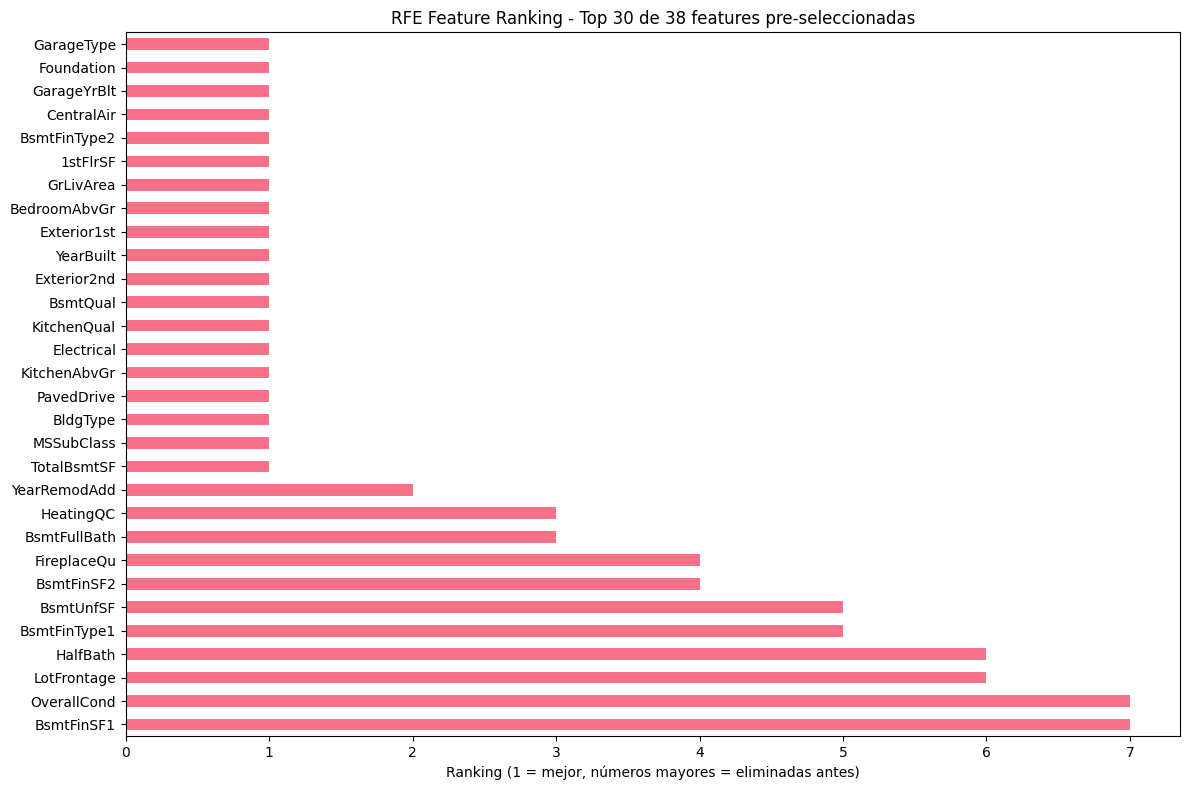

In [17]:
from sklearn.feature_selection import RFE

# ========== TWO-STAGE SELECTION: PCA + RFE ==========
print("\n=== WRAPPER METHOD: RFE (Recursive Feature Elimination) ===")
print("💡 ESTRATEGIA: RFE sobre features pre-seleccionadas por PCA")
print(f"   Stage 1 (ya hecho): PCA Loadings → {len(selected_features_pca)} features")
print(f"   Stage 2 (ahora): RFE → refinar a {k_wrapper} features")
print("⏱️ Esto tomará ~45-90 segundos...\n")

# Ajuste defensivo por si k_wrapper > #features disponibles
k_wrapper = min(k_wrapper, X_pca_selected.shape[1])

# TODO: RFE con Random Forest Regressor sobre features pre-seleccionadas
estimator = RandomForestRegressor(
    random_state=42, 
    n_estimators=50,   # ← rápido y suficiente para ranking
    max_depth=10,      # ← limita complejidad y acelera
    n_jobs=-1
)
selector_rfe = RFE(estimator=estimator, n_features_to_select=k_wrapper, step=2)  # ← elimina 2 por iteración

print(f"🔄 Ejecutando RFE sobre {len(selected_features_pca)} features...")
import time
start_time = time.time()
X_rfe = selector_rfe.fit_transform(X_pca_selected, y)
elapsed_time = time.time() - start_time

print(f"✅ RFE completado en {elapsed_time:.1f} segundos")

# Features seleccionadas (mapear índices de vuelta a nombres)
selected_indices_rfe = selector_rfe.get_support()
selected_features_rfe = [selected_features_pca[i] for i, sel in enumerate(selected_indices_rfe) if sel]

print(f"\n✅ Features seleccionadas por RFE ({len(selected_features_rfe)}):")
for i, feat in enumerate(selected_features_rfe, 1):
    print(f"  {i:2d}. {feat}")

# Ranking de features (solo sobre las pre-seleccionadas por PCA)
ranking = pd.Series(selector_rfe.ranking_, index=selected_features_pca).sort_values()
print(f"\nRanking de features (1 = seleccionada, solo mostrando top 20):")
print(ranking.head(20))

# Visualizar ranking (top 30 para claridad)
plt.figure(figsize=(12, 8))
ranking.head(30).sort_values(ascending=False).plot(kind='barh')
plt.xlabel('Ranking (1 = mejor, números mayores = eliminadas antes)')
plt.title(f'RFE Feature Ranking - Top 30 de {len(selected_features_pca)} features pre-seleccionadas')
plt.tight_layout()
plt.show()

### Paso 4.4: Comparación de Features Seleccionadas (Todos los Wrapper Methods)¶


In [18]:
# Comparar features seleccionadas por diferentes métodos
print("\n=== COMPARACIÓN DE FEATURES SELECCIONADAS ===")

# Crear conjunto de features por método
features_dict = {
    'F-test': set(selected_features_f),
    'Mutual Info': set(selected_features_mi),
    'Forward': set(selected_features_forward),
    'Backward': set(selected_features_backward),
    'RFE': set(selected_features_rfe)
}

# Features en al menos 2 métodos
all_features = set()
for features in features_dict.values():
    all_features.update(features)

feature_counts = {}
for feature in all_features:
    count = sum(1 for features in features_dict.values() if feature in features)
    feature_counts[feature] = count

# Features consistentes (en todos los métodos)
consistent_features = [f for f, count in feature_counts.items() if count == 3]
print(f"\nFeatures consistentes (en todos los métodos): {len(consistent_features)}")
print(consistent_features)

# Features en al menos 2 métodos
robust_features = [f for f, count in feature_counts.items() if count >= 2]
print(f"\nFeatures robustas (≥2 métodos): {len(robust_features)}")
print(robust_features)

print("\n💡 OBSERVACIÓN:")
print(f"   Forward, Backward y RFE son todos wrapper methods, pero usan estrategias diferentes")


=== COMPARACIÓN DE FEATURES SELECCIONADAS ===

Features consistentes (en todos los métodos): 6
['Electrical', '2ndFlrSF', 'MSSubClass', 'TotRmsAbvGrd', 'GarageYrBlt', 'LotFrontage']

Features robustas (≥2 métodos): 44
['Electrical', 'GarageCars', 'BsmtFullBath', 'KitchenQual', 'GarageFinish', 'YearBuilt', 'GarageArea', 'Neighborhood', 'OverallCond', 'BedroomAbvGr', 'HalfBath', 'MasVnrType', 'CentralAir', 'MasVnrArea', 'GrLivArea', 'KitchenAbvGr', 'LotArea', '2ndFlrSF', 'Exterior1st', 'Foundation', '1stFlrSF', 'YearRemodAdd', 'PavedDrive', 'GarageType', 'ExterQual', 'LotShape', 'BsmtQual', 'WoodDeckSF', 'BsmtUnfSF', 'MSSubClass', 'TotRmsAbvGrd', 'BsmtFinSF1', 'FullBath', 'TotalBsmtSF', 'RoofStyle', 'GarageYrBlt', 'BsmtFinType1', 'OpenPorchSF', 'Fireplaces', 'Exterior2nd', 'LotFrontage', 'HeatingQC', 'OverallQual', 'FireplaceQu']

💡 OBSERVACIÓN:
   Forward, Backward y RFE son todos wrapper methods, pero usan estrategias diferentes


### Paso 4.5: Evaluar Performance de Wrapper Methods¶


In [19]:
# ========== EVALUACIÓN: FORWARD SELECTION ==========
print("\n=== EVALUANDO WRAPPER METHODS ===")
print("⏱️ Cross-validation con features de cada método...\n")

print("🔄 Evaluando Forward Selection...")
rf_forward = RandomForestRegressor(random_state=42, n_estimators=100, max_depth=15, n_jobs=-1)

scores_mse_forward = -cross_val_score(rf_forward, X_forward, y, cv=5, 
                                       scoring='neg_mean_squared_error', n_jobs=-1)
scores_r2_forward = cross_val_score(rf_forward, X_forward, y, cv=5, 
                                    scoring='r2', n_jobs=-1)
rmse_forward = np.sqrt(scores_mse_forward)

print(f"✅ Forward Selection ({len(selected_features_forward)} features):")
print(f"   RMSE: ${rmse_forward.mean():,.0f} ± ${rmse_forward.std():,.0f}")
print(f"   R²:   {scores_r2_forward.mean():.4f} ± {scores_r2_forward.std():.4f}")

# ========== EVALUACIÓN: BACKWARD ELIMINATION ==========
print(f"\n🔄 Evaluando Backward Elimination...")
rf_backward = RandomForestRegressor(random_state=42, n_estimators=100, max_depth=15, n_jobs=-1)

scores_mse_backward = -cross_val_score(rf_backward, X_backward, y, cv=5, 
                                         scoring='neg_mean_squared_error', n_jobs=-1)
scores_r2_backward = cross_val_score(rf_backward, X_backward, y, cv=5, 
                                      scoring='r2', n_jobs=-1)
rmse_backward = np.sqrt(scores_mse_backward)

print(f"✅ Backward Elimination ({len(selected_features_backward)} features):")
print(f"   RMSE: ${rmse_backward.mean():,.0f} ± ${rmse_backward.std():,.0f}")
print(f"   R²:   {scores_r2_backward.mean():.4f} ± {scores_r2_backward.std():.4f}")

# ========== EVALUACIÓN: RFE ==========
print(f"\n🔄 Evaluando RFE...")
rf_rfe = RandomForestRegressor(random_state=42, n_estimators=100, max_depth=15, n_jobs=-1)

scores_mse_rfe = -cross_val_score(rf_rfe, X_rfe, y, cv=5, 
                                   scoring='neg_mean_squared_error', n_jobs=-1)
scores_r2_rfe = cross_val_score(rf_rfe, X_rfe, y, cv=5, 
                                scoring='r2', n_jobs=-1)
rmse_rfe = np.sqrt(scores_mse_rfe)

print(f"✅ RFE ({len(selected_features_rfe)} features):")
print(f"   RMSE: ${rmse_rfe.mean():,.0f} ± ${rmse_rfe.std():,.0f}")
print(f"   R²:   {scores_r2_rfe.mean():.4f} ± {scores_r2_rfe.std():.4f}")

# ========== COMPARACIÓN ACTUALIZADA ==========
print(f"\n" + "="*80)
print(f"{'COMPARACIÓN: TODOS LOS MÉTODOS HASTA AHORA':^80}")
print(f"="*80)

comparison_updated = {
    'Método': ['Original', 'PCA Componentes', 'PCA Loadings', 'F-test', 'MI', 'Forward', 'Backward', 'RFE'],
    'N_Features': [X.shape[1], n_components_80, k, k, k, k, k, k],
    'RMSE': [rmse_original.mean(), rmse_pca.mean(), rmse_pca_selected.mean(), rmse_filter_f.mean(), 
             rmse_filter_mi.mean(), rmse_forward.mean(), rmse_backward.mean(), rmse_rfe.mean()],
    'R²': [scores_r2_original.mean(), scores_r2_pca.mean(), scores_r2_pca_selected.mean(), scores_r2_filter_f.mean(), 
           scores_r2_filter_mi.mean(), scores_r2_forward.mean(), scores_r2_backward.mean(), scores_r2_rfe.mean()]
}
comparison_updated_df = pd.DataFrame(comparison_updated)
comparison_updated_df['Reducción%'] = (1 - comparison_updated_df['N_Features'] / X.shape[1]) * 100
comparison_updated_df = comparison_updated_df.sort_values('RMSE')

print(f"\n{comparison_updated_df.to_string(index=False)}")

print(f"\n💡 OBSERVACIÓN:")
best_method = comparison_updated_df.iloc[0]['Método']
best_rmse = comparison_updated_df.iloc[0]['RMSE']
print(f"   🏆 Mejor RMSE: {best_method} (${best_rmse:,.0f})")


=== EVALUANDO WRAPPER METHODS ===
⏱️ Cross-validation con features de cada método...

🔄 Evaluando Forward Selection...
✅ Forward Selection (19 features):
   RMSE: $31,127 ± $5,029
   R²:   0.8448 ± 0.0343

🔄 Evaluando Backward Elimination...
✅ Backward Elimination (19 features):
   RMSE: $30,848 ± $4,803
   R²:   0.8481 ± 0.0294

🔄 Evaluando RFE...
✅ RFE (19 features):
   RMSE: $31,066 ± $4,658
   R²:   0.8458 ± 0.0295

                   COMPARACIÓN: TODOS LOS MÉTODOS HASTA AHORA                   

         Método  N_Features         RMSE       R²  Reducción%
             MI          38 29313.791183 0.862702   51.898734
         F-test          38 29643.479987 0.859709   51.898734
       Original          79 29644.541158 0.859299    0.000000
PCA Componentes          38 30829.572155 0.848120   51.898734
       Backward          38 30848.096018 0.848093   51.898734
   PCA Loadings          38 30957.861536 0.846615   51.898734
            RFE          38 31065.957572 0.845766   51.8987

## Parte 5: Feature Selection - Embedded Methods (15 min)¶

### Paso 5.1: Random Forest Feature Importance¶




=== EMBEDDED METHODS: Random Forest ===
Top 10 features por importancia:
GrLivArea      0.038607
LotArea        0.037522
TotalBsmtSF    0.035274
BsmtUnfSF      0.034858
GarageArea     0.033896
1stFlrSF       0.033171
YearBuilt      0.033145
LotFrontage    0.030427
GarageYrBlt    0.026635
BsmtFinSF1     0.024762
dtype: float64


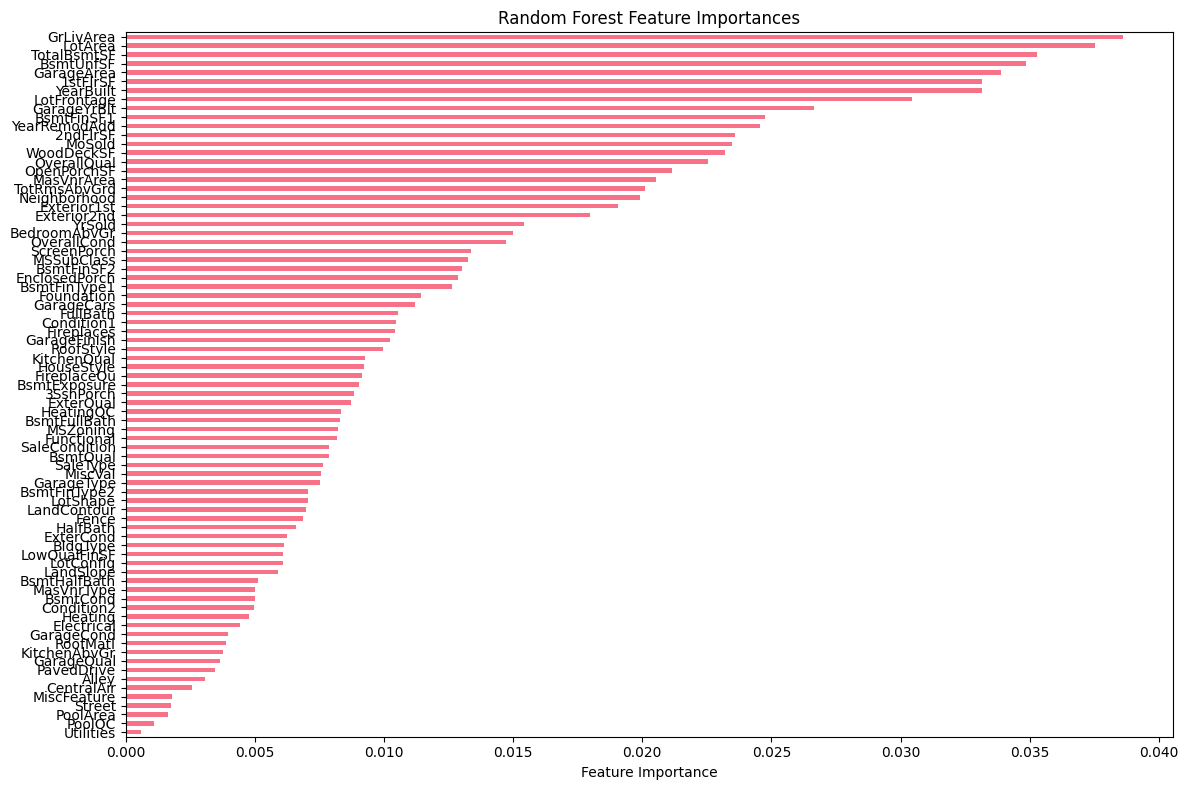


Features seleccionadas por RF Importance (38):
['GrLivArea', 'LotArea', 'TotalBsmtSF', 'BsmtUnfSF', 'GarageArea', '1stFlrSF', 'YearBuilt', 'LotFrontage', 'GarageYrBlt', 'BsmtFinSF1', 'YearRemodAdd', '2ndFlrSF', 'MoSold', 'WoodDeckSF', 'OverallQual', 'OpenPorchSF', 'MasVnrArea', 'TotRmsAbvGrd', 'Neighborhood', 'Exterior1st', 'Exterior2nd', 'YrSold', 'BedroomAbvGr', 'OverallCond', 'ScreenPorch', 'MSSubClass', 'BsmtFinSF2', 'EnclosedPorch', 'BsmtFinType1', 'Foundation', 'GarageCars', 'FullBath', 'Condition1', 'Fireplaces', 'GarageFinish', 'RoofStyle', 'KitchenQual', 'HouseStyle']

RMSE RF Importance (38 features): $44,917 ± $5,990

RF Importance (38 features):
  Mean: 0.013
  Std: 0.003


In [20]:
# TODO: Entrenar Random Forest y obtener importances
print("\n=== EMBEDDED METHODS: Random Forest ===")
from sklearn.ensemble import RandomForestClassifier

rf_embedded = RandomForestClassifier(random_state=42, n_estimators=200, max_depth=10)
rf_embedded.fit(X_scaled, y)

# Feature importances
importances = pd.Series(rf_embedded.feature_importances_, index=X.columns).sort_values(ascending=False)
print("Top 10 features por importancia:")
print(importances.head(10))

# Visualizar importances
plt.figure(figsize=(12, 8))
importances.sort_values(ascending=True).plot(kind='barh')
plt.xlabel('Feature Importance')
plt.title('Random Forest Feature Importances')
plt.tight_layout()
plt.show()

# TODO: Seleccionar top-k features
top_k_features = importances.nlargest(k).index
X_rf_importance = X_scaled[:, X.columns.isin(top_k_features)]

print(f"\nFeatures seleccionadas por RF Importance ({k}):")
print(list(top_k_features))

# Evaluar
rmse_rf_importance = np.sqrt(-cross_val_score(rf_embedded, X_rf_importance, y, cv=5, scoring='neg_mean_squared_error'))
print(f"\nRMSE RF Importance ({k} features): ${rmse_rf_importance.mean():,.0f} ± ${rmse_rf_importance.std():,.0f}")
scores_rf_importance = cross_val_score(rf_embedded, X_rf_importance, y, cv=5, scoring='accuracy')
print(f"\nRF Importance ({k} features):")
print(f"  Mean: {scores_rf_importance.mean():.3f}")
print(f"  Std: {scores_rf_importance.std():.3f}")


### Paso 5.2: Lasso (L1 Regularization para Regresión)¶



=== EMBEDDED METHOD: Lasso (L1 Regularization) ===
Lasso penaliza coeficientes, forzando a 0 features no importantes
⏱️ Esto puede tomar 30-60 segundos...

✅ Lasso alpha seleccionado: 1023.7448

📊 Features con coeficiente no-cero: 49 de 79

✅ Top 38 features por magnitud de coeficiente Lasso:
   1. GrLivArea           : |22517.693267|
   2. OverallQual         : |16896.106925|
   3. BsmtQual            : |8064.432883|
   4. GarageCars          : |7182.203112|
   5. KitchenQual         : |7049.486538|
   6. ExterQual           : |6740.969115|
   7. PoolQC              : |5606.203095|
   8. MSSubClass          : |5558.096916|
   9. YearBuilt           : |5101.017284|
  10. MasVnrArea          : |4109.089880|
  11. OverallCond         : |4031.073100|
  12. BsmtFinSF1          : |3774.191593|
  13. PoolArea            : |3762.971612|
  14. LotArea             : |3582.925003|
  15. Fireplaces          : |3477.078529|
  16. BsmtExposure        : |3332.378684|
  17. Functional          : |27

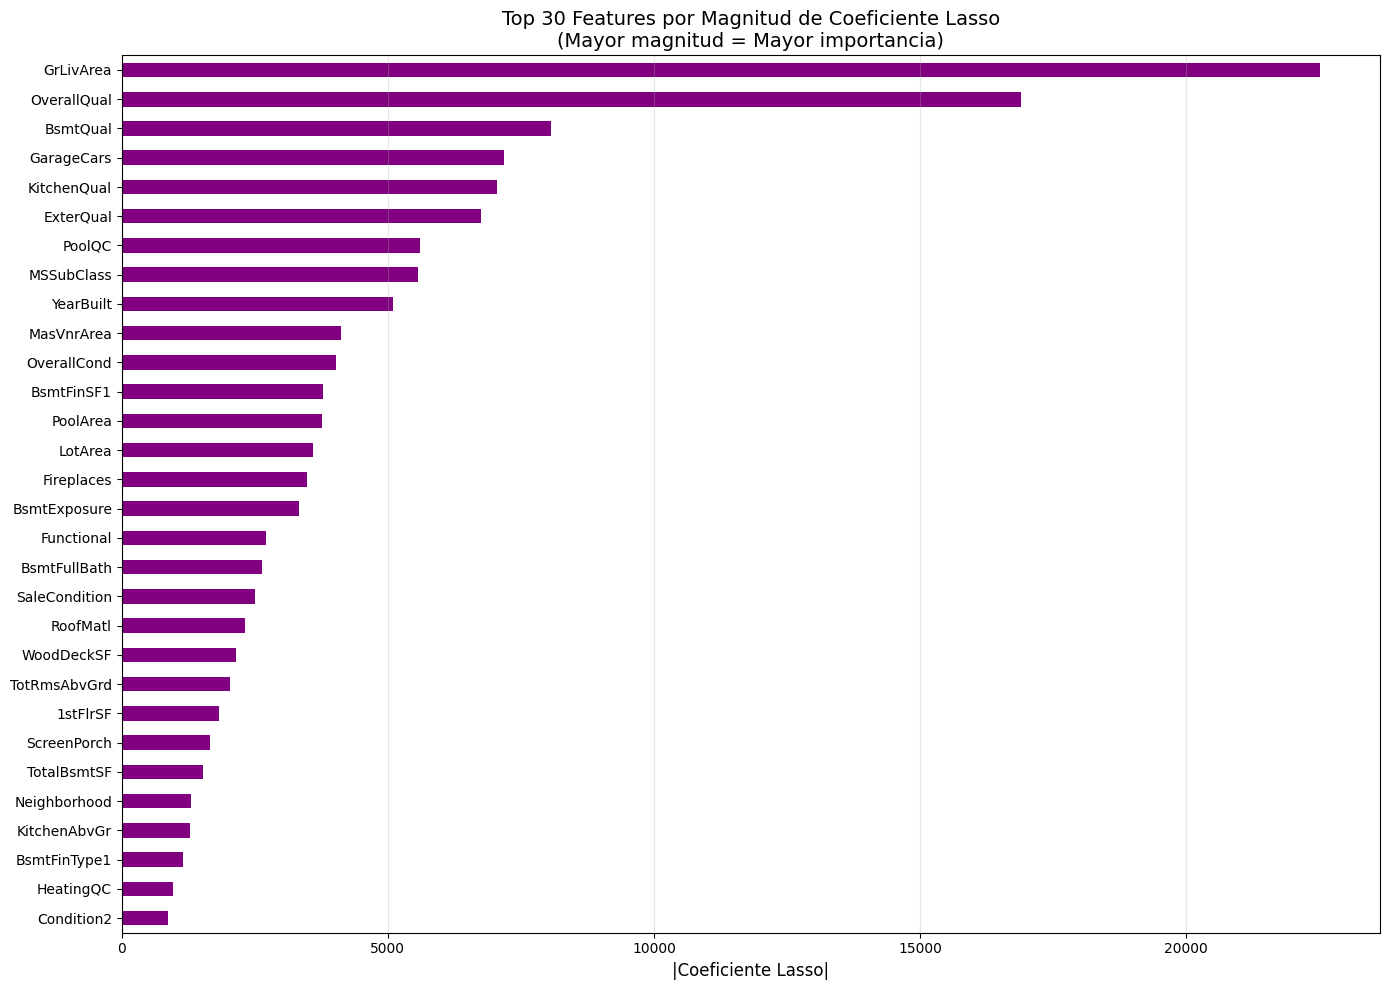


🔄 Evaluando Lasso selection...
✅ Lasso selection (38 features):
   RMSE: $29,327 ± $3,607
   R²:   0.8626 ± 0.0203


In [21]:
from sklearn.linear_model import LassoCV

# ========== LASSO PARA FEATURE SELECTION ==========
print("\n=== EMBEDDED METHOD: Lasso (L1 Regularization) ===")
print("Lasso penaliza coeficientes, forzando a 0 features no importantes")
print("⏱️ Esto puede tomar 30-60 segundos...\n")

# TODO: Lasso para regresión
lasso = LassoCV(cv=5, random_state=42, max_iter=10000)
lasso.fit(X_scaled, y)

print(f"✅ Lasso alpha seleccionado: {lasso.alpha_:.4f}")

# Features seleccionadas (coef != 0)
lasso_nonzero = X.columns[lasso.coef_ != 0]
print(f"\n📊 Features con coeficiente no-cero: {len(lasso_nonzero)} de {X.shape[1]}")

# Seleccionar top-k por magnitud de coeficiente
coef_abs = pd.Series(np.abs(lasso.coef_), index=X.columns).sort_values(ascending=False)
lasso_features = coef_abs.nlargest(k).index

print(f"\n✅ Top {k} features por magnitud de coeficiente Lasso:")
for i, (feat, coef) in enumerate(coef_abs.nlargest(k).items(), 1):
    print(f"  {i:2d}. {feat:20s}: |{coef:.6f}|")

# TODO: Visualizar coeficientes (top 30)
plt.figure(figsize=(14, 10))
coef_abs.head(30).sort_values(ascending=True).plot(kind='barh', color='purple')
plt.xlabel('|Coeficiente Lasso|', fontsize=12)
plt.title('Top 30 Features por Magnitud de Coeficiente Lasso\n(Mayor magnitud = Mayor importancia)', fontsize=14)
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.show()

# Preparar features para evaluación
X_lasso = X_scaled[:, X.columns.isin(lasso_features)]

# ========== EVALUAR CON RANDOM FOREST ==========
print(f"\n🔄 Evaluando Lasso selection...")
rf_lasso = RandomForestRegressor(random_state=42, n_estimators=100, max_depth=15, n_jobs=-1)

scores_mse_lasso = -cross_val_score(rf_lasso, X_lasso, y, cv=5, 
                                     scoring='neg_mean_squared_error', n_jobs=-1)
scores_r2_lasso = cross_val_score(rf_lasso, X_lasso, y, cv=5, 
                                  scoring='r2', n_jobs=-1)
rmse_lasso = np.sqrt(scores_mse_lasso)

print(f"✅ Lasso selection ({k} features):")
print(f"   RMSE: ${rmse_lasso.mean():,.0f} ± ${rmse_lasso.std():,.0f}")
print(f"   R²:   {scores_r2_lasso.mean():.4f} ± {scores_r2_lasso.std():.4f}")